In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% ! important; }<style>"))

## prepare

In [3]:

import numpy as np
from numpy import searchsorted
from astropy.io import fits
import matplotlib.pylab as plt
import os

import matplotlib
%matplotlib notebook


from matplotlib import rcParams
import matplotlib as mpl

from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib.gridspec import GridSpec

from astropy import units,constants

from astropy.table import Column
from astropy.time import Time

from scipy.interpolate import interp1d
from astropy.table import Table, Column


from scipy.signal import savgol_filter

from scipy.integrate import trapz
import pysynphot as S

from kapteyn import kmpfit

In [81]:
from collections import OrderedDict
import pandas as pd
pd.set_option('display.max_rows', None, 'display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [86]:

def galactic_reddening_NED(target, flt):
    '''
    Get the Galactic Extinction from NED 'http://ned.ipac.caltech.edu/'
    '''

    A_lambda = {'2022jli': {'U': 0.193,
                                'B': 0.161,
                                'V': 0.122,
                                'R': 0.096,
                                'I': 0.067,
                                'u': 0.189,
                                'g': 0.147,
                                'r': 0.102,
                                'i': 0.076,
                                'z': 0.056,
                                'J': 0.032,
                                'H': 0.020,
                                'K': 0.013,
                                'L': 0.007}}

    return A_lambda[target][flt]


def galactic_dereddening_swift_bands(flt, AV, spec_type='BB_10000K'):
    '''

    The value for U B V r i from NED

    For swift bands the extinction are adopted from 
    'http://iopscience.iop.org/0004-637X/721/2/1608/suppdata/apj343574t14_mrt.txt'

    which is a table for R_X, where A_X = R_X*E(B-V) in filter X = W2, M2, W1, U, B, V

    '''

    RX = {'SN_1992A': {'W2': 6.44, 'M2': 8.06, 'W1': 5.45, 'U': 4.91, 'B': 4.16, 'V': 3.16},
          'SN_1994I': {'W2': 6.32, 'M2': 8.30, 'W1': 5.35, 'U': 4.88, 'B': 4.10, 'V': 3.14},
          'SN_1999em': {'W2': 7.63, 'M2': 8.37, 'W1': 6.18, 'U': 5.00, 'B': 4.16, 'V': 3.16},
          'BB_2000K': {'W2': 2.65, 'M2': 4.90, 'W1': 3.33, 'U': 4.65, 'B': 3.92, 'V': 3.09},
          'BB_2200K': {'W2': 2.83, 'M2': 5.32, 'W1': 3.52, 'U': 4.71, 'B': 3.95, 'V': 3.10},
          'BB_2400K': {'W2': 3.03, 'M2': 5.79, 'W1': 3.71, 'U': 4.75, 'B': 3.97, 'V': 3.11},
          'BB_2600K': {'W2': 3.23, 'M2': 6.22, 'W1': 3.91, 'U': 4.79, 'B': 3.98, 'V': 3.11},
          'BB_2800K': {'W2': 3.45, 'M2': 6.58, 'W1': 4.12, 'U': 4.81, 'B': 4.00, 'V': 3.12},
          'BB_3000K': {'W2': 3.70, 'M2': 6.86, 'W1': 4.32, 'U': 4.83, 'B': 4.01, 'V': 3.12},
          'BB_3200K': {'W2': 3.97, 'M2': 7.07, 'W1': 4.53, 'U': 4.85, 'B': 4.02, 'V': 3.13},
          'BB_3400K': {'W2': 4.26, 'M2': 7.25, 'W1': 4.72, 'U': 4.86, 'B': 4.04, 'V': 3.13},
          'BB_3600K': {'W2': 4.57, 'M2': 7.39, 'W1': 4.90, 'U': 4.87, 'B': 4.05, 'V': 3.13},
          'BB_3800K': {'W2': 4.87, 'M2': 7.51, 'W1': 5.07, 'U': 4.88, 'B': 4.06, 'V': 3.13},
          'BB_4000K': {'W2': 5.18, 'M2': 7.61, 'W1': 5.22, 'U': 4.89, 'B': 4.06, 'V': 3.14},
          'BB_4200K': {'W2': 5.47, 'M2': 7.70, 'W1': 5.35, 'U': 4.90, 'B': 4.07, 'V': 3.14},
          'BB_4400K': {'W2': 5.74, 'M2': 7.77, 'W1': 5.48, 'U': 4.91, 'B': 4.08, 'V': 3.14},
          'BB_4600K': {'W2': 6.00, 'M2': 7.84, 'W1': 5.59, 'U': 4.92, 'B': 4.08, 'V': 3.14},
          'BB_4800K': {'W2': 6.23, 'M2': 7.90, 'W1': 5.69, 'U': 4.92, 'B': 4.09, 'V': 3.14},
          'BB_5000K': {'W2': 6.44, 'M2': 7.96, 'W1': 5.78, 'U': 4.93, 'B': 4.10, 'V': 3.15},
          'BB_5200K': {'W2': 6.63, 'M2': 8.01, 'W1': 5.86, 'U': 4.93, 'B': 4.10, 'V': 3.15},
          'BB_5600K': {'W2': 6.95, 'M2': 8.09, 'W1': 6.00, 'U': 4.94, 'B': 4.11, 'V': 3.15},
          'BB_6000K': {'W2': 7.21, 'M2': 8.17, 'W1': 6.12, 'U': 4.95, 'B': 4.12, 'V': 3.15},
          'BB_6600K': {'W2': 7.50, 'M2': 8.25, 'W1': 6.27, 'U': 4.96, 'B': 4.13, 'V': 3.15},
          'BB_7000K': {'W2': 7.64, 'M2': 8.30, 'W1': 6.35, 'U': 4.97, 'B': 4.13, 'V': 3.15},
          'BB_8000K': {'W2': 7.89, 'M2': 8.40, 'W1': 6.52, 'U': 4.98, 'B': 4.14, 'V': 3.16},
          'BB_9000K': {'W2': 8.05, 'M2': 8.47, 'W1': 6.64, 'U': 4.99, 'B': 4.15, 'V': 3.16},
          'BB_10000K': {'W2': 8.14, 'M2': 8.53, 'W1': 6.74, 'U': 5.00, 'B': 4.16, 'V': 3.16},
          'BB_12000K': {'W2': 8.25, 'M2': 8.60, 'W1': 6.89, 'U': 5.01, 'B': 4.17, 'V': 3.16},
          'BB_13000K': {'W2': 8.27, 'M2': 8.63, 'W1': 6.94, 'U': 5.01, 'B': 4.17, 'V': 3.17},
          'BB_14000K': {'W2': 8.29, 'M2': 8.65, 'W1': 6.99, 'U': 5.01, 'B': 4.18, 'V': 3.17},
          'BB_15000K': {'W2': 8.31, 'M2': 8.67, 'W1': 7.03, 'U': 5.02, 'B': 4.18, 'V': 3.17},
          'BB_20000K': {'W2': 8.33, 'M2': 8.73, 'W1': 7.17, 'U': 5.03, 'B': 4.19, 'V': 3.17},
          'BB_25000K': {'W2': 8.33, 'M2': 8.76, 'W1': 7.25, 'U': 5.03, 'B': 4.19, 'V': 3.17},
          'BB_30000K': {'W2': 8.33, 'M2': 8.78, 'W1': 7.30, 'U': 5.04, 'B': 4.20, 'V': 3.17},
          'BB_35000K': {'W2': 8.33, 'M2': 8.79, 'W1': 7.33, 'U': 5.04, 'B': 4.20, 'V': 3.17}}

    A_X_mag = AV/RX[spec_type]['V']*RX[spec_type][flt]

    return A_X_mag


def Vega_AB_mag_convertion(mag, flt, mode, direction='Vega2AB'):
    '''
    transform the magnitude from vega system to AB magnitude system

    For mode == 'Swift', ref to "http://swift.gsfc.nasa.gov/analysis/uvot_digest/zeropts.html"

    For mode == 'Bessell', refer to 'http://www.astronomy.ohio-state.edu/~martini/usefuldata.html'
    These data are mostly from Blanton et al. (2007)


    INPUT:
    mode: 'Swift' or 'Bessell'
    direction: 'Vega2AB' or 'AB2Vega'

    '''

    if mode not in ['Swift', 'Bessell']:
        raise IOError('Only Swift and Bessell bands are supported now!')

    # Values for m_AB - m_Vega
    offset_dict = {'Swift': {'V': -0.01,
                             'B': -0.13,
                             'U': +1.02,
                             'W1': +1.51,
                             'M2': +1.69,
                             'W2': +1.73,
                             'White': +0.80},
                   'Bessell': {'U': +0.79,
                               'B': -0.09,
                               'V': +0.02,
                               'R': +0.21,
                               'I': +0.45,
                               'J': +0.91,
                               'H': +1.39,
                               'K': +1.85,
                               'u': +0.91,
                               'g': -0.08,
                               'r': +0.16,
                               'i': +0.37,
                               'z': +0.54,
                               'Y': +0.634}}
    if direction == 'Vega2AB':
        mag_new = mag + offset_dict[mode][flt]
    elif direction == 'AB2Vega':
        mag_new = mag - offset_dict[mode][flt]
    else:
        raise IOError('directions Vega2AB or AB2Vega are supported!')

    return mag_new


def mag2flux(mag, flt=None, bp_mp=None, mode='wavelength', I_unit='cgs', wavelength_units='Angstroms'):
    '''
    convert magnitude in AB system into flux

    if 'I_unit' == 'Jy' then F_nu in Jy unit; 
    if 'I_unit' == 'cgs' then F_nu in  unit of erg/s/cm^2/Hz; 

    F_lambda is in unit of erg/s/cm^2/A
    '''
    f0_nu = 3631  # Jy
    if flt is None and bp_mp is None:
        raise ValueError('no input of wavelength')

    if mode == 'frequency':
        f0 = f0_nu*1e-23  # frequence F_\nu = 3631 Jy and 1 Jy = 10^-23 erg/s/cm^2/Hz
    elif mode == 'wavelength':

        if bp_mp is None:
            bp_mp = get_weff(flt)

        f0_lambda = f0_nu / (3.34*10**4*bp_mp**2)  # erg/s/cm^2/A
        f0 = f0_lambda
    else:
        raise IOError(
            'unrecognized mode for experssion of zero point of flux!')

    if bp_mp is None:
        lam = get_weff(flt)
    else:
        lam = bp_mp

    flux = f0*10**(-0.4*mag)

    return lam, flux


def get_weff(flt):
    lambda_eff_dict = {'W2': 2030.5,
                       'M2': 2228.1,
                       'W1': 2589.1,
                       'UVOT_U': 3501.2,
                       'UVOT_B': 4328.6,
                       'UVOT_V': 5402.1,
                       'U': 3462.8,
                       'B': 4379.7,
                       'R': 6400,
                       'I': 7900,
                       'J': 12600,
                       'H': 16000,
                       'K': 22200,
                       'u': 3608,
                       'g': 5200,
                       'V': 5485.1,
                       'r': 6169.5,
                       'i': 7496.6,
                       'z': 9100,
                       'G': 5822,
                        'c':5182.4,
                        'o':6630,
                       'unit': 'Angstroms'}

    return lambda_eff_dict[flt]


def flux2mag(flux, flt, bp_mp=None,  mode='wavelength', I_unit='cgs', wavelength_units='Angstroms'):
    '''
    convert magnitude in AB system into flux

    if 'I_unit' == 'Jy' then F_nu in Jy unit; 
    if 'I_unit' == 'cgs' then F_nu in  unit of erg/s/cm^2/Hz; 

    F_lambda is in unit of erg/s/cm^2/A
    '''
    f0_nu = 3631  # Jy

    if mode == 'frequency':
        f0 = f0_nu*1e-23  # frequence F_\nu = 3631 Jy and 1 Jy = 10^-23 erg/s/cm^2/Hz
    elif mode == 'wavelength':
        if bp_mp is None:
            bp_mp = get_weff(flt)
        f0_lambda = f0_nu / (3.34*10**4*bp_mp**2)  # erg/s/cm^2/A
        f0 = f0_lambda
    else:
        raise IOError(
            'unrecognized mode for experssion of zero point of flux!')

    mag = -2.5*np.log10(flux/f0)

    return mag


unitdict = {'cgs': {'h': 6.626068e-27,
                    'k': 1.3806503e-16,
                    'c': 2.99792458e10,
                    'mh': 1.67262158e-24 * 1.00794,
                    'length': 'cm'},
            'mks': {'h': 6.626068e-34,
                    'k': 1.3806503e-23,
                    'c': 2.99792458e8,
                    'mh': 1.67262158e-27 * 1.00794,
                    'length': 'm'}
            }

wavelength_dict = {'meters': 1.0, 'm': 1.0,
                   'centimeters': 1e-2, 'cm': 1e-2,
                   'millimeters': 1e-3, 'mm': 1e-3,
                   'nanometers': 1e-9, 'nm': 1e-9,
                   'micrometers': 1e-6, 'micron': 1e-6, 'microns': 1e-6, 'um': 1e-6,
                   'kilometers': 1e3, 'km': 1e3,
                   'angstroms': 1e-10, 'A': 1e-10, 'Angstroms': 1e-10,
                   }


def blackbody_wavelength(lam, temperature, scale=1.0, units='cgs', wavelength_units='Angstroms', normalize=max, beta=0):
    '''
    INPUTS:
            lam:
            temperature:

    '''
    # load constants in desired units
    h, k, c = unitdict[units]['h'], unitdict[units]['k'], unitdict[units]['c']

    # converta lambd to cm/m
    lam = lam * wavelength_dict[wavelength_units] / \
        (1e-2 if units == 'cgs' else 1)

    I = 2*h*c**2 / lam**5 * (exp(h*c/(k*temperature*lam)) - 1)**-1

    if normalize and hasattr(I, '__len__'):
        if len(I) > 1:
            return I/normalize(I) * scale
        else:
            return I * scale
    else:
        return I * scale


def BB_angs_cgs(p, x):
    '''
    input wavelength in angstrom and temperaute in K
    the output intensity density in erg/s/cm^2/A/sr
    '''
    scale, T = p
    h, k, c = unitdict['cgs']['h'], unitdict['cgs']['k'], unitdict['cgs']['c']
    x = x*1e-8
    I = 2*h*c**2 / x**5 * (np.exp(h*c/(k*T*x)) - 1)**-1
    return scale*I*1e-8 # without *1e-8 the unit is erg/s/cm^2/cm/sr
    
def BB_residual(p, data):
    x, y, yerr = data
    model = BB_angs_cgs(p, x)
    return (y-model)/yerr




def fit_blackbody_kmpfit(x, y, yerr, params0 = None):
    '''
    blackbody fitting 
    '''
    
    fitdata = [x, y, yerr]

    if params0 is None:
        T0 = 10000
        ys0 = BB_angs_cgs([1, T0], x)
        scale0 = np.mean(y)/np.mean(ys0)
        params0 = [scale0, T0]
    print(params0)
    
    fitobj = kmpfit.Fitter(residuals=BB_residual, data=fitdata)

    fitobj.fit(params0=params0)

    return fitobj


def fit_blackbody_lmfit(xdata, flux, guesses=(0, 0), err=None, blackbody_function=blackbody_wavelength, quiet=True, **kwargs):
    """
    Parameters
    ----------
    xdata : array
        Array of the X-values (frequency, wavelength) of the data
    flux : array
        The fluxes corresponding to the xdata values
    guesses : (Temperature,Scale) or (Temperature,Beta,Scale)
        The input guesses.  3 parameters are used for greybody
        fitting, two for temperature fitting.
    blackbody_function: function
        Must take x-axis (e.g. frequency), temperature, scale, and then
        optionally beta args
    quiet : bool
        quiet flag passed to mpfit

    kwargs are past to blackbody function

    Examples
    --------
    >>> wavelength = np.array([20,70,160,250,350,500,850,1100])
    >>> flux = modified_blackbody_wavelength(wavelength, 15, beta=1.75,
            wavelength_units='microns', normalize=False, logN=22, logscale=16)
    >>> err = 0.1 * flux
    >>> flux += np.random.randn(len(wavelength)) * err
    >>> tguess, bguess, nguess = 20.,2.,21.5
    >>> lm = fit_blackbody_lmfit(wavelength, flux, err=err,
             blackbody_function=modified_blackbody_wavelength, logscale=16,
             guesses=(tguess,bguess,nguess),
             wavelength_units='microns')
    >>> print lm.params

    >>> # If you want to fit for a fixed beta, do this:
    >>> parameters = lmfit.Parameters(OrderedDict([ (n,lmfit.Parameter(x)) for n,x
            in zip(('T','beta','N'),(20.,2.,21.5)) ]))
    >>> import lmfit
    >>> parameters['beta'].vary = False
    >>> lm = fit_blackbody_lmfit(wavelength, flux, err=err,
             blackbody_function=modified_blackbody_wavelength, logscale=16,
             guesses=parameters,
             wavelength_units='microns')
    >>> print lm.params
    """

    def lmfitfun(x, y, err):
        if err is None:
            def f(p): return (y-blackbody_function(x, *
                                                   [p[par].value for par in p], normalize=False, **kwargs))
        else:
            def f(p): return (y-blackbody_function(x, *
                                                   [p[par].value for par in p], normalize=False, **kwargs))/err
        return f

    if not isinstance(guesses, lmfit.Parameters):
        guesspars = lmfit.Parameters(OrderedDict([(n, lmfit.Parameter(
            value=x, name=n)) for n, x in zip(('T', 'beta', 'N'), guesses)]))
    else:
        guesspars = guesses

    minimizer = lmfit.minimize(lmfitfun(xdata, np.array(flux), err),
                               guesspars)

    return minimizer


def read_and_prepare_mags(data, flts):
    '''
    Read data into data dictionary 
    'data' format: JD mag1 magerr1 mag2 magerr2 mag3 magerr3 mag4 magerr4...
    flts =[flt1 flt2 flt3 flt4 ...]
    '''

    data_dict = {}
    data_err_dict = {}

    for i, flt in enumerate(flts):

        data_dict[flt] = data[2*i+1]
        data_err_dict[flt] = data[2*i+2]

    return data_dict, data_err_dict


def get_SED_AB_mag(sed_input_data, target_name=None, A_V=None, correct_gal_extinction=False):
    '''
    INPUTS:
            sed_input_data: if file, it should have the following format

                    #flt    mag    magerr    sys
                     B      13.5   0.04      Vega
                     g      14.5   0.03      AB
                     r      14.0   0.00      AB
            otherwise, it should be a table as read from the above file
    '''

    lambda_eff_dict = {'W2': 2056.6,
                       'M2': 2246.4,
                       'W1': 2581.0,
                       'U': 3462.8,
                       'B': 4379.7,
                       'V': 5485.1,
                       'R': 6400,
                       'I': 7900,
                       'J': 12600,
                       'H': 16000,
                       'K': 22200,
                       'u': 3608,
                       'g': 5200,
                       'r': 6169.5,
                       'i': 7496.6,
                       'z': 9100,
                        'G':5822,
                        'c':5182.4,
                        'o':6630}
    
    if type(sed_input_data) is str and os.path.isfile(sed_input_data):
        data = Table.read(sed_input_data, format='ascii')
    else:
        data = sed_input_data.copy()

    flts = []
    lams = []
    mags = []
    magerrs = []
    
    swift_flts = ['W1', 'M2', 'W2']

    for fltdata in data:
        flt = fltdata['flt']
        if flt in ['UVW1', 'UVM2', 'UVW2']:
            flt  = flt[2:4]
        flts.append(flt)
        lams.append(lambda_eff_dict[flt])
        magsys = fltdata['sys']
        mag = fltdata['mag']

        if correct_gal_extinction:
            if flt in swift_flts:
                if A_V is None:
                    A_V = galactic_reddening_NED(target_name, 'V')
                A_mag = galactic_dereddening_swift_bands(flt, A_V, spec_type='BB_10000K')
                mag = mag - A_mag
            else:
                if target_name is not None:
                    try:
                        A_mag = galactic_reddening_NED(target_name, flt)
                        mag = mag - A_mag
                    except:
                        print(
                            "extinction for %s not implemented in bolometric_toolkit.py yet" % target_name)

        magerr = fltdata['magerr']

        if magsys == 'AB':
            mags.append(mag)
            magerrs.append(magerr)
        else:
            if flt in swift_flts:
                mag_AB = Vega_AB_mag_convertion(
                    mag, flt, 'Swift', direction='Vega2AB')
            else:
                mag_AB = Vega_AB_mag_convertion(
                    mag, flt, 'Bessell', direction='Vega2AB')
            mags.append(mag_AB)
            magerrs.append(magerr)

    output_data = [flts, lams, mags, magerrs]
    output_table = Table(output_data, names=('flt', 'lam', 'mag', 'magerr'))

    return output_table




def get_SED_flux(sed_mags_table, waveeff_dict=None,  target_name=None):
    '''
    INPUTS:
            sed_mags_table:

    '''
    lams = []
    fluxs = []
    fluxerrs = []

    for fltdata in sed_mags_table:
        flt = fltdata['flt']
        mag = fltdata['mag']
        magerr = fltdata['magerr']

        if (waveeff_dict is not None) and (flt in waveeff_dict.keys()):
            bp_mp = waveeff_dict[flt]
        else:
            bp_mp = None

        lamb, flux = mag2flux(mag, flt, bp_mp=bp_mp, mode='wavelength', I_unit='cgs', wavelength_units='Angstroms')
        lamb, flux_upper = mag2flux(mag-magerr, flt, bp_mp=bp_mp, mode='wavelength', I_unit='cgs', wavelength_units='Angstroms')
        fluxerr = flux_upper - flux

        lams.append(lamb)
        fluxs.append(flux)
        fluxerrs.append(fluxerr)

    output_data = [lams, fluxs, fluxerrs]
    output_table = Table(output_data, names=('lam', 'flux', 'fluxerr'))

    return output_table


def spectrum_flux_calibrate(specdata, filter_curves, calflts, cal_abmags, polyorder=1, display=0, nircal=0, verbose=0):
    '''
    specdata:
    filter_curves: a dictionary with keyword as the filter name and value as the filter response curve data
    calflts: a list of filter in which the photometry is available to calibrate the spectrum 
    cal_abmags: AB magnitudes measurements for the input spectrum; in table format with columns of filter, mag, and magerr 
    '''
    specwave = specdata[:,0]
    specflux = specdata[:,1]
    
    synwaves = []
    synfluxs = []
    obswaves = []
    obsfluxs = []

    for flt in calflts:
        synwave, synflux, synmag = mag_flux_from_spec_bandpass(flt, specwave, specflux, filter_curves[flt][:, 0], filter_curves[flt][:, 1], fill_mode=1, display=False, verbose=verbose)
        synwaves.append(synwave)
        synfluxs.append(synflux)
        lamtemp, obsflux = mag2flux(cal_abmags[cal_abmags['flt'] == flt]['mag'].data[0], bp_mp=synwave)
        obsfluxs.append(obsflux)

    factors = np.array(obsfluxs)/np.array(synfluxs)        
    polyobj = polyfit(np.array(synwaves), factors, np.ones(len(factors))*0.05, polyorder)
    polyfunc = polyfunctions(polyorder)
    
    
    if display:
        fig, (ax0, ax, ax2) = plt.subplots(3, 1, figsize=(16, 8), sharex=True)
        ax.plot(specdata[:, 0], specdata[:, 1])

        if not nircal:
            for flt in filter_curves.keys():
                #print(flt)
                if flt[:-1] == 'ztf':
                    color = 'k'
                elif flt[:-1] == 'lcogt':
                    color = 'c'
                elif flt[:-1] == 'lt':
                    color = 'm'
                elif flt[:-1] == 'sdss':
                    color = 'b'
                else:
                    color = 'g'
                ax0.plot(filter_curves[flt][:, 0], filter_curves[flt][:, 1], color=color)     
                
            ax2.plot(np.linspace(3400, 9700,  200), polyfunc(polyobj.params, np.linspace(3400, 9700,  200)))
            ax.set_xlim(2500, 11000)
        else:
            ax0.plot(filter_curves['J'][:, 0], filter_curves['J'][:, 1], color='r')    
            ax2.plot(np.linspace(9500, 20000,  200), polyfunc(polyobj.params, np.linspace(3400, 9700,  200)))
            ax.set_xlim(9000, 21000)                
            
        ax.plot(synwaves, synfluxs, 'yo', label='syn mag')
        ax.plot(synwaves, obsfluxs, 'go', label='phot obs mag')
        ax2.plot(synwaves, factors, 'ko')

        
        ax.legend(loc=0)

        for flt, wave, factor in zip(calflts, synwaves, factors):
            ax2.text(wave, factor, flt)

        #ax2.set_ylim([0.5, 2.5])
        ax2.grid()
        
    return polyfunc, polyobj





def mag_flux_from_spec_bandpass(flt, spec_wave, spec_flux, bp_wave, bp_resp, fill_mode = 0, display=False, verbose=True):
    ''' 
    first calculate pivot wavelength, then calculate integrant flux
    
    INPUTS:
        fill_mode: 0 --> fill_value = 0; -1 --> fill_value = spec_flux[0]; 1 --> fill_value = spec_flux[-1]  #assuming the flux is sorted to wavelength
    '''

    if fill_mode == 0:
        fill_value = 0
    elif fill_mode == -1:
        fill_value = spec_flux[0]
    elif fill_mode == 1:
        fill_value = spec_flux[-1]
    else:
        raise ValueError('fill_mode=%s not supported'%fill_mode)
        
    spec_interp = interp1d(spec_wave, spec_flux, bounds_error=False, fill_value=fill_value)
    pivot_wave = np.sqrt(trapz(bp_resp*bp_wave, x=bp_wave) /
                         trapz(bp_resp/bp_wave, x=bp_wave))
    flux_interg = trapz(bp_wave*bp_resp*spec_interp(bp_wave),
                        x=bp_wave)/trapz(bp_wave*bp_resp, x=bp_wave)
    mag = flux2mag(flux_interg, flt, bp_mp=pivot_wave)
    if verbose:
        print("flux %s at %s A ---> magnitude %s" %
              (flux_interg, pivot_wave, mag))

    return pivot_wave, flux_interg, mag

def spectrum_extinction_effect(wave, flux, EBV, extmodel='gal3', compare_display=False):
    ''' 
    apply or remove the effects of interstellar reddening on a source spectrum using Extinction provided bypysynphot. 

    INPUTS:
            wave: spectrum wavelength
            flux: spectrum flux
            EBV: extinction is defined R(V) = A(V)/E(B-V); negative value effectively dereddens the spectrum
            extmodel: extinction model, see here for details http://pysynphot.readthedocs.io/en/latest/spectrum.html

    '''
    sp = S.ArraySpectrum(wave=wave, flux=flux,
                         waveunits='angstrom', fluxunits='flam', keepneg=True)
    sp_deext = sp*S.Extinction(EBV, extmodel)

    wave_out = sp_deext.wave
    flux_out = sp_deext.flux

    if compare_display:
        plt.plot(sp.wave, sp.flux)
        plt.plot(sp_deext.wave, sp_deext.flux)
        plt.show()

    mask = np.logical_and(wave_out >= np.min(wave), wave_out <= np.max(wave))

    return wave_out[mask], flux_out[mask]


def wavelength_convert_air_vacuum(lambda1, verbose=1):
	'''
	lambda_air = lambda_vac / n; where n is tmospheric refractivity

	n = 1 + 6.4328e-5 + (2.94981e6)/(1.46e10-sigma**2) + (2.5540e4)/(4.1e9-sigma**2); (old) where sigma is wave number

	n = 1 + 8.34213e-5 + (2.406030e6)/(1.30e10-sigma**2) + (1.5997e4)/(3.89e9-sigma**2)

	'''
	
	sigma = 1.0/lambda1*1e8

	#n = 1 + 6.4328e-5 + (2.94981e6)/(1.46e10-sigma**2) + (2.5540e4)/(4.1e9-sigma**2)
	n = 1 + 8.34213e-5 + (2.406030e6)/(1.30e10-sigma**2) + (1.5997e4)/(3.89e9-sigma**2)

	lambda2 = lambda1/n

	if verbose:
		print ("The atmospheric refractivity at %s angstrom is %s"%(lambda1, n))

	return lambda2



In [115]:


def poly1(p, x):
    a0, a1 = p
    return a0+a1*x


def resd_poly1(p, data):
    x, y, yerr = data
    model = poly1(p, x)
    return (y-model)/yerr

def poly2(p, x):
    a0, a1, a2 = p
    return a0+a1*x+a2*x**2


def resd_poly2(p, data):
    x, y, yerr = data
    model = poly2(p, x)
    return (y-model)/yerr

def poly3(p, x):
    a0, a1, a2, a3 = p
    return a0+a1*x+a2*x**2+a3*x**3


def resd_poly3(p, data):
    x, y, yerr = data
    model = poly3(p, x)
    return (y-model)/yerr

def poly4(p, x):
    a0, a1, a2, a3, a4 = p
    return a0+a1*x+a2*x**2+a3*x**3+a4*x**4


def resd_poly4(p, data):
    x, y, yerr = data
    model = poly4(p, x)
    return (y-model)/yerr

def poly5(p, x):
    a0, a1, a2, a3, a4, a5 = p
    return a0+a1*x+a2*x**2+a3*x**3+a4*x**4+a5*x**5


def resd_poly5(p, data):
    x, y, yerr = data
    model = poly5(p, x)
    return (y-model)/yerr

def poly6(p, x):
    a0, a1, a2, a3, a4, a5, a6 = p
    return a0+a1*x+a2*x**2+a3*x**3+a4*x**4+a5*x**5+a6*x**6


def resd_poly6(p, data):
    x, y, yerr = data
    model = poly6(p, x)
    return (y-model)/yerr


def polyfit(x, y, yerr, polyorder):

    fitdata = [x, y, yerr]
    if polyorder not in [1, 2, 3, 4, 5,6]:
        raise ValueError("the polynomial orders options: 1, 2,3,4,5,6")
    else:
        if polyorder == 1:
            resd_poly = resd_poly1
            polymodel = poly1
            params0 = [1, 0]                
        if polyorder == 2:
            resd_poly = resd_poly2
            polymodel = poly2
            params0 = [1, 0, 0]            
        if polyorder == 3:
            resd_poly = resd_poly3
            polymodel = poly3
            params0 = [1, 0, 0, 0]
        if polyorder == 4:
            resd_poly = resd_poly4
            polymodel = poly4
            params0 = [1, 0, 0, 0, 0]
        if polyorder == 5:
            resd_poly = resd_poly5
            polymodel = poly5
            params0 = [1, 0, 0, 0, 0, 0]
        if polyorder == 6:
            resd_poly = resd_poly6
            polymodel = poly6
            params0 = [1, 0, 0, 0, 0, 0,0]
            
    fitobj = kmpfit.Fitter(residuals=resd_poly, data=fitdata)

    # print "Input fit data: "
    # print fitdata
    fitobj.fit(params0=params0)

    return fitobj

In [82]:



def get_mag_table(lctable, bands=None, bandcolname='flt', obstimecolname='obstime', calmagcol='calmag', calmagerrcol='calmagerr', instmagerrcol='instmagerr', dt=1.0, outfile=None, binning=True):
    if bands is None:
        bands = np.unique(lctable[bandcolname])
    #print(bands)
    if binning:
        lctable = lctable[[obstimecolname, bandcolname, calmagcol, calmagerrcol, instmagerrcol]]
    else:
        lctable = lctable[[obstimecolname, bandcolname, calmagcol, calmagerrcol]]
    lctable.sort(obstimecolname)
    times = lctable[obstimecolname].data

    tbins = np.arange(times.min()+dt*0.5, times.max()+dt, dt)
    bids = searchsorted(tbins, times)
    #print('bids:', bids)

    gtimes = np.array([np.mean(times[bids == i]) for i in range(len(tbins))])
    #print('gtimes:', gtimes)

    gids = ~np.isnan(gtimes)
    #print('gids:', gids)

    table_datadict = OrderedDict()
    table_datadict['jd'] = []
    
    for band in bands:
        table_datadict[band] = []
        table_datadict['e'+band] = []
        table_datadict['binepoch_'+band] = []

    for i, bid in enumerate(np.unique(bids)): #go through each bin 
        gtable = lctable[bids == bid]
        gtable.sort(obstimecolname)

        gtime_mean = gtimes[gids][i]
        #print(gtime_mean)

        tempdict = OrderedDict()
        nrows = []
        for band in bands:
            tempdict[band] = gtable[gtable[bandcolname] == band]
            nrows.append(len(tempdict[band]))
        
        if binning: #binning data within each bin
            table_datadict['jd'].append(gtime_mean)
            for band in bands:
                if band not in tempdict.keys():
                    table_datadict[band].append(np.nan)
                    table_datadict['e'+band].append(np.nan)
                    table_datadict['binepoch_'+band].append(0)
                elif len(tempdict[band]) == 1:
                    table_datadict[band].append(tempdict[band][calmagcol].data[0])
                    table_datadict['e'+band].append(tempdict[band][calmagerrcol].data[0])
                    table_datadict['binepoch_'+band].append(1)
                else:
                    n = len(tempdict[band])
                    weights = 1.0/tempdict[band][calmagerrcol].data**2
                    mags = tempdict[band][calmagcol].data
                    photcalerrs = np.sqrt(tempdict[band][calmagerrcol].data**2 - tempdict[band][instmagerrcol].data**2)
                    wtm = np.sum(mags*weights)/np.sum(weights)
                    err_wtm = np.sqrt((np.sum(mags**2*weights)/np.sum(weights) - wtm**2) /(n-1)) #this deal with standard error of weighted average 
                    
                    err_cal = np.sum(photcalerrs)/n
                    table_datadict[band].append(wtm)
                    table_datadict['e'+band].append(np.sqrt(err_wtm**2+ err_cal**2/n))
                    table_datadict['binepoch_'+band].append(n)
                    
        else: #get all without binning                
            for j in np.arange(np.max(nrows)):
                table_datadict['jd'].append(gtime_mean)
                for band in bands:
                    if j >=len(tempdict[band]):
                        table_datadict[band].append(np.nan)
                        table_datadict['e'+band].append(np.nan)
                        table_datadict['binepoch_'+band].append(0)
                    else:
                        table_datadict[band].append(tempdict[band][calmagcol].data[j])
                        table_datadict['e'+band].append(tempdict[band][calmagerrcol].data[j])
                        table_datadict['binepoch_'+band].append(1)

    data = [table_datadict[key] for key in table_datadict.keys()]
    lctable = Table(data, names=table_datadict.keys())

    lcpd = pd.DataFrame(np.array(data).transpose(), columns=table_datadict.keys())


    return(lcpd, lctable)

In [88]:
filter_curves = {}

uvotu = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/SWIFT_UVOT/Swift_UVOT.U.dat')
uvotb = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/SWIFT_UVOT/Swift_UVOT.B.dat')
uvotv = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/SWIFT_UVOT/Swift_UVOT.V.dat')
uvm2  = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/SWIFT_UVOT/Swift_UVOT.UVM2.dat')
uvw1  = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/SWIFT_UVOT/Swift_UVOT.UVW1.dat')
uvw2  = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/SWIFT_UVOT/Swift_UVOT.UVW2.dat')

lcogtu = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/lco_filter_curves/SDSS.up.lambA.txt')
lcogtB = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/lco_filter_curves/bssl-bx-004.lambA.txt')
lcogtV = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/lco_filter_curves/bssl-vx-022.lambA.txt')
lcogtg = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/lco_filter_curves/SDSS.gp.lambA.txt')
lcogtr = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/lco_filter_curves/SDSS.rp.lambA.txt')
lcogti = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/lco_filter_curves/SDSS.ip.lambA.txt')

sdssu = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/SDSS/SLOAN_SDSS.u.dat')
sdssg = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/SDSS/SLOAN_SDSS.g.dat')
sdssr = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/SDSS/SLOAN_SDSS.r.dat')
sdssi = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/SDSS/SLOAN_SDSS.i.dat')
sdssz = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/SDSS/SLOAN_SDSS.z.dat')

ltu = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/LT_filters/from_svo/Liverpool_IOO.SDSS-u.dat')
ltg = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/LT_filters/from_svo/Liverpool_IOO.SDSS-g.dat')
ltr = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/LT_filters/from_svo/Liverpool_IOO.SDSS-r.dat')
lti = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/LT_filters/from_svo/Liverpool_IOO.SDSS-i.dat')
ltz = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/LT_filters/from_svo/Liverpool_IOO.SDSS-z.dat')
ltB = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/LT_filters/from_svo/Liverpool_IOO.B.dat')
ltV = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/LT_filters/from_svo/Liverpool_IOO.V.dat')

gaiaG = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/Gaia/Gaia3/GAIA_GAIA3.G.dat')
atlaso = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/ATLAS_survey/Misc_Atlas.orange.dat')
atlasc = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/ATLAS_survey/Misc_Atlas.cyan.dat')
efoscV = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/NTT_EFOSC/LaSilla_EFOSC.ESO641.dat')
JohnsonR = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/Generic/Johnson/Generic_Johnson.R.dat')


ztfg = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/Palomar/ZTF/Palomar_ZTF.g.dat')
ztfr = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/Palomar/ZTF/Palomar_ZTF.r.dat')
ztfi = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/Palomar/ZTF/Palomar_ZTF.i.dat')
sofiJ = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/NTT_SOFI/J.dat')
sofiH = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/NTT_SOFI/H.dat')
sofiKs = np.loadtxt('/Users/chenping/SNeData/Ping_collections/filter_curves/NTT_SOFI/Ks.dat')
sofiJ[:,0] = sofiJ[:,0]*10000
sofiH[:,0] = sofiH[:,0]*10000
sofiKs[:,0] = sofiKs[:,0]*10000

filter_curves['uvotu'] = uvotu
filter_curves['uvotb'] = uvotb
filter_curves['uvotv'] = uvotv
filter_curves['uvotw1']= uvw1
filter_curves['uvotw2']= uvw2
filter_curves['uvotm2']= uvm2

filter_curves['lcogtu'] = lcogtu
filter_curves['lcogtB'] = lcogtB
filter_curves['lcogtV'] = lcogtV
filter_curves['lcogtg'] = lcogtg
filter_curves['lcogtr'] = lcogtr
filter_curves['lcogti'] = lcogti

filter_curves['u'] = sdssu
filter_curves['B'] = uvotb
filter_curves['V'] = uvotv
filter_curves['g'] = ztfg
filter_curves['r'] = ztfr
filter_curves['i'] = ztfi
filter_curves['z'] = ltz

filter_curves['ztfg'] = ztfg
filter_curves['ztfr'] = ztfr
filter_curves['ztfi'] = ztfi

filter_curves['ltu'] = ltu
filter_curves['ltg'] = ltg
filter_curves['ltr'] = ltr
filter_curves['lti'] = lti
filter_curves['ltz'] = ltz


filter_curves['sdssu'] = sdssu
filter_curves['sdssg'] = sdssg
filter_curves['sdssr'] = sdssr
filter_curves['sdssi'] = sdssi
filter_curves['sdssz'] = sdssz

filter_curves['J'] = sofiJ
filter_curves['H'] = sofiH
filter_curves['Ks'] = sofiKs

filter_curves['G'] = gaiaG
filter_curves['R'] = JohnsonR
filter_curves['c'] = atlasc
filter_curves['o'] = atlaso
filter_curves['efoscV'] = efoscV

## load spectra 

In [69]:
## 2022jli

import pickle

z_22jli  = 0.0055
EBV_host = 0.25
EBV_mw = 0.039
EBV = EBV_host + EBV_mw#total EBV, MW+host 

#if previous saved result available
outfile = '/Users/chenping/SNeData/Ping_collections/SNe_spectra/2022jli.20230301.p'
with open(outfile, 'rb') as fp:
    specs_22jli = pickle.load(fp)

spectable = specs_22jli['spectable']
spectable.sort('phase')

spectable.show_in_notebook()

idx,specname,phase,bump_phase,date,jd,specfile,telescope,instrument,exptime
0,psh0511,5.973749999888241,11.696212311275303,2022-05-11.143,2459710.64375,./spectra/tns/tns_2022jli_2022-05-11_03-27-00_Other_Other_PSH.dat,other,other,999
1,efosc0524,19.247025463264436,12.469487774651498,2022-05-24.417,2459723.917025463,./spectra/tns/tns_2022jzy_2022-05-24_10-00-31_ESO-NTT_EFOSC2-NTT_ePESSTO+.asci,NTT,EFOSC2,999
2,sedm0629,55.253703703638166,10.976166015025228,2022-06-29.423,2459759.9237037036,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220629_10_10_08_ZTF22aapubuy.txt,P60,SEDM,1800
3,sedm0707,63.254224536940455,6.4766868483275175,2022-07-07.424,2459767.924224537,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220707_10_10_53_ZTF22aapubuy.txt,P60,SEDM,1800
4,sedm0719,75.28391203703359,6.00637434842065,2022-07-19.453,2459779.953912037,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220719_10_53_38_ZTF22aapubuy.txt,P60,SEDM,1800
5,sedm0726,82.16870370367542,0.39116601506248116,2022-07-26.338,2459786.8387037036,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220726_08_07_44_ZTF22aapubuy.txt,P60,SEDM,1800
6,sedm0804,91.24891203688458,9.471374348271638,2022-08-04.418,2459795.918912037,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220804_10_03_14_ZTF22aapubuy.txt,P60,SEDM,1800
7,not0806,93.02682870393619,11.249291015323251,2022-08-06.196,2459797.696828704,./spectra/fritz/spectrum_1d.ascii,NOT,ALFOSC,999
8,sedm0811,98.14078703708947,3.863249348476529,2022-08-11.310,2459802.810787037,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220811_07_27_32_ZTF22aapubuy.txt,P60,SEDM,1800
9,sedm0816,103.11894675949588,8.841409070882946,2022-08-16.288,2459807.7889467594,./spectra/fritz/spec_auto_robot_lstep1__crr_b_ifu20220816_06_56_05_ZTF22aapubuy.txt,P60,SEDM,1800


In [40]:
## get the spectra of SN 2013ge

TmaxB_13ge = 56615.7+2400000.5 #from table 7 of https://iopscience.iop.org/article/10.3847/0004-637X/821/1/57
EBV_13ge = 0.067
z_13ge = 0.004356


sn2013ge_dir = '../data/comparison_sne/2013ge/'
spectable_13ge_wiserep = Table.read('../data/comparison_sne/2013ge/wiserep_spectra.csv', format='ascii.csv')

specinfo_13ge = {}


phases = []
specnames = []
for jd, specfile in spectable_13ge_wiserep[['JD', 'Ascii file']]:
    #print(jd, specfile)
    phase = jd- TmaxB_13ge
    phases.append(phase)
    specname = str(np.around(phase,1))+'d'
    specnames.append(specname)
    try:
        specdata = np.loadtxt(os.path.join(sn2013ge_dir, specfile))
    except:
        specdata = np.loadtxt(os.path.join(sn2013ge_dir, specfile), skiprows=1) 
    specinfo_13ge[specname] = {}
    specinfo_13ge[specname]['phase'] = phase
    specinfo_13ge[specname]['spec'] = specdata
    
spectable_13ge_wiserep.add_column(Column(phases, name='phase'))
spectable_13ge_wiserep.add_column(Column(specnames, name='specname'))

print(len(spectable_13ge_wiserep))

printtable = spectable_13ge_wiserep[['specname', 'Ascii file','JD', 'phase']]
printtable.pprint_all()

40
specname                         Ascii file                               JD              phase       
-------- --------------------------------------------------------- --------------- -------------------
  -10.7d          2013ge_2013-11-09_00-00-00_MMT_MMT-Blue_None.flm       2456605.5 -10.700000000186265
   -9.7d          2013ge_2013-11-10_00-00-00_MMT_MMT-Blue_None.flm       2456606.5  -9.700000000186265
   -9.7d        2013ge_2013-11-10_00-00-00_MMT_MMT-Blue_None_0.flm       2456606.5  -9.700000000186265
   -8.7d          2013ge_2013-11-11_00-00-00_MMT_MMT-Blue_None.flm       2456607.5  -8.700000000186265
    0.3d   2013ge_2013-11-20_00-00-00_Magellan-Baade_FIRE_None.flm       2456616.5  0.2999999998137355
    1.3d         2013ge_2013-11-21_00-00-00_MMT_Hectospec_None.flm       2456617.5  1.2999999998137355
    8.8d SN_2013ge_2013-11-28_11-25-26_Lick-3m_KAST_UCB-SNDB_0.flm 2456624.9759954   8.775995399802923
    9.3d         2013ge_2013-11-29_00-00-00_MMT_Hectospec_None.flm    

## get bolomtric correction

In [62]:
bc_phase  = []   #spec phase
bc_nir_frac = [] # = nir/(opt+nir)

#### +10d

<IPython.core.display.Javascript object>


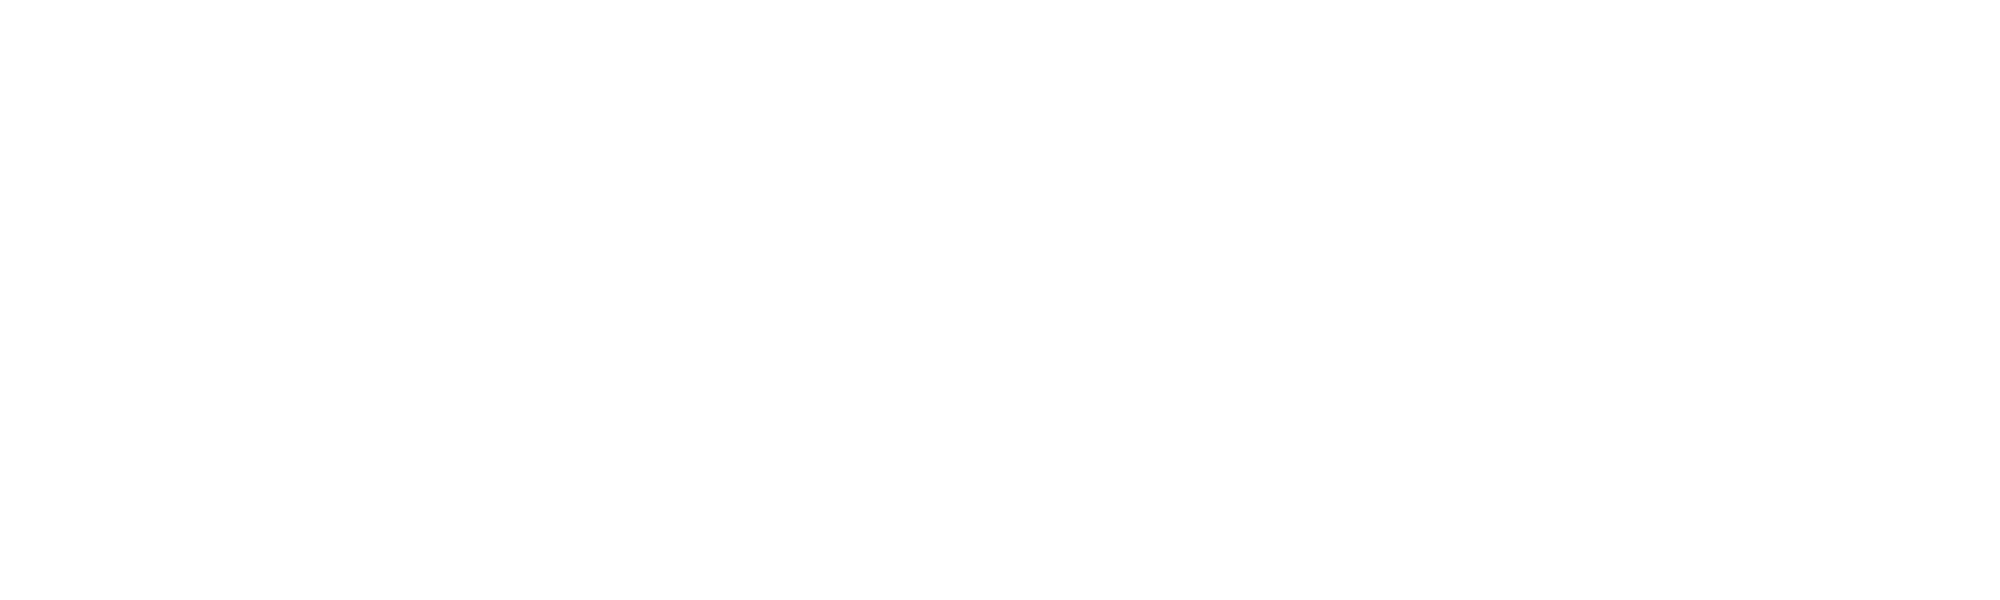

0.23920095364901606
1.3144075361244132


In [63]:
#we don't have early spec data 
#let's check for one similar to 2022jli, i.e., 2013ge
fig, ax = plt.subplots(figsize=(20,6), sharex=True)

specname = '9.3d'
spec = specinfo_13ge[specname]['spec']
xs = spec[:,0]/(1+z_13ge)
ys = spec[:,1]*1e-15
xs_new, ys_new = spectrum_extinction_effect(xs, ys, -EBV_13ge, extmodel='gal3', compare_display=False)
ax.plot(xs, ys, 'k--', alpha=0.1)
ax.plot(xs_new, ys_new, 'k', label='SN2013ge 9.3d ')


opt_w1 = 3750
opt_w2 = 9150
mask = (xs_new>opt_w1)*(xs_new<opt_w2)
opt = trapz(ys_new[mask], x=xs_new[mask]) ##to get the correction factor for the NIR light 

specname = '10.3d'
spec = specinfo_13ge[specname]['spec']
xs = spec[:,0]/(1+z_13ge)
ys = spec[:,1]*0.1
xs_new, ys_new = spectrum_extinction_effect(xs, ys, -EBV_13ge, extmodel='gal3', compare_display=False)
ax.plot(xs, ys, 'r--', alpha=0.1)
ax.plot(xs_new, ys_new, 'r', label='SN2013ge 10.3d')

nir_w1 = 9150
nir_w2 = 25000
mask = (xs_new>nir_w1)*(xs_new<nir_w2)
nir = trapz(ys_new[mask], x=xs_new[mask])

ax.legend(loc=0)


ax.fill_between([opt_w1, opt_w2], [7e-15, 7e-15], [0, 0], alpha=0.2, color='c', edgecolor='none')
ax.fill_between([nir_w1, nir_w2], [7e-15, 7e-15], [0, 0], alpha=0.2, color='r', edgecolor='none')
ax.text(6548, 6.5e-15, 'optical', rotation=0, ha='center')
ax.text(15000, 3.5e-15, 'NIR', rotation=0, ha='center')
ax.set_title("nir/(opt+nir) = %s"%np.round(nir/(opt+nir), 3))

print(nir/(opt+nir))
print((nir+opt)/opt)


bc_phase.append(10)
bc_nir_frac.append(nir/(opt+nir))

#### +20d

<IPython.core.display.Javascript object>


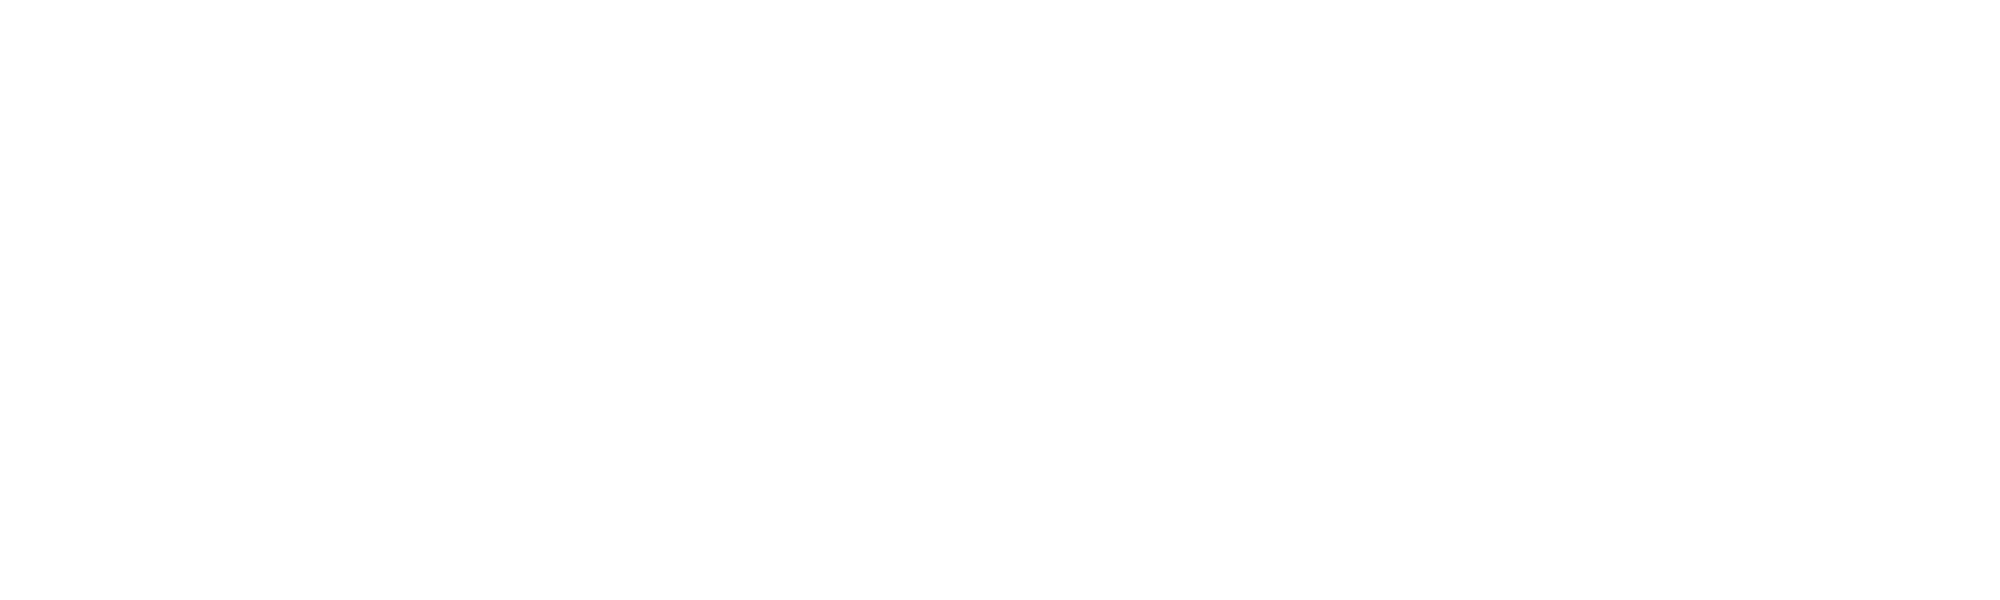

0.36005901775282617
1.5626440995987896


In [64]:
#efosc 2022-05-04 spec


fig, ax = plt.subplots(figsize=(20,6))


spec = specs_22jli['efosc0524']['spec']  
xs = spec[:,0]/(1+z_22jli)
ys = spec[:,1]
xs_new, ys_new = spectrum_extinction_effect(xs, ys, -EBV, extmodel='gal3', compare_display=False)
ax.plot(xs, ys, alpha=0.2)
ax.plot(xs_new, ys_new, 'b', label='2022jli 2022-05-24')


opt_w1 = 3750
opt_w2 = 9150
mask = (xs_new>opt_w1)*(xs_new<opt_w2)
opt = trapz(ys_new[mask], x=xs_new[mask]) ##to get the correction factor for the NIR light 

# specname = '20.3d'
# spec = specinfo_13ge[specname]['spec']
# xs = spec[:,0]/(1+z_13ge)
# ys = spec[:,1]*2e-15
# ax.plot(xs, ys, 'r', label='SN2013ge 20.3d')


specname = '19.3d'
spec = specinfo_13ge[specname]['spec']
xs = spec[:,0]/(1+z_13ge)
ys = spec[:,1]*0.2
xs_new, ys_new = spectrum_extinction_effect(xs, ys, -EBV_13ge, extmodel='gal3', compare_display=False)
ax.plot(xs, ys, 'r--', alpha=0.1)
ax.plot(xs_new, ys_new, 'r', label='SN2013ge 19.3d')


nir_w1 = 9150
nir_w2 = 25000
mask = (xs_new>nir_w1)*(xs_new<nir_w2)
nir = trapz(ys_new[mask], x=xs_new[mask])


# specname = '10.3d'
# spec = specinfo_13ge[specname]['spec']
# xs = spec[:,0]/(1+z_13ge)
# ys = spec[:,1]*0.2
# ax.plot(xs, ys, 'k--', label='SN2013ge 10.3d')

ax.legend(loc=0)


ax.fill_between([opt_w1, opt_w2], [8e-15, 8e-15], [0, 0], alpha=0.2, color='c', edgecolor='none')
ax.fill_between([nir_w1, nir_w2], [7e-15, 7e-15], [0, 0], alpha=0.2, color='r', edgecolor='none')
ax.text(6548, 7.5e-15, 'optical', rotation=0, ha='center')
ax.text(15000, 3.5e-15, 'NIR', rotation=0, ha='center')
ax.set_title("nir/(opt+nir) = %s"%np.round(nir/(opt+nir), 3))

print(nir/(opt+nir))
print((nir+opt)/opt)


bc_phase.append(20)
bc_nir_frac.append(nir/(opt+nir))

#### +107d

<IPython.core.display.Javascript object>


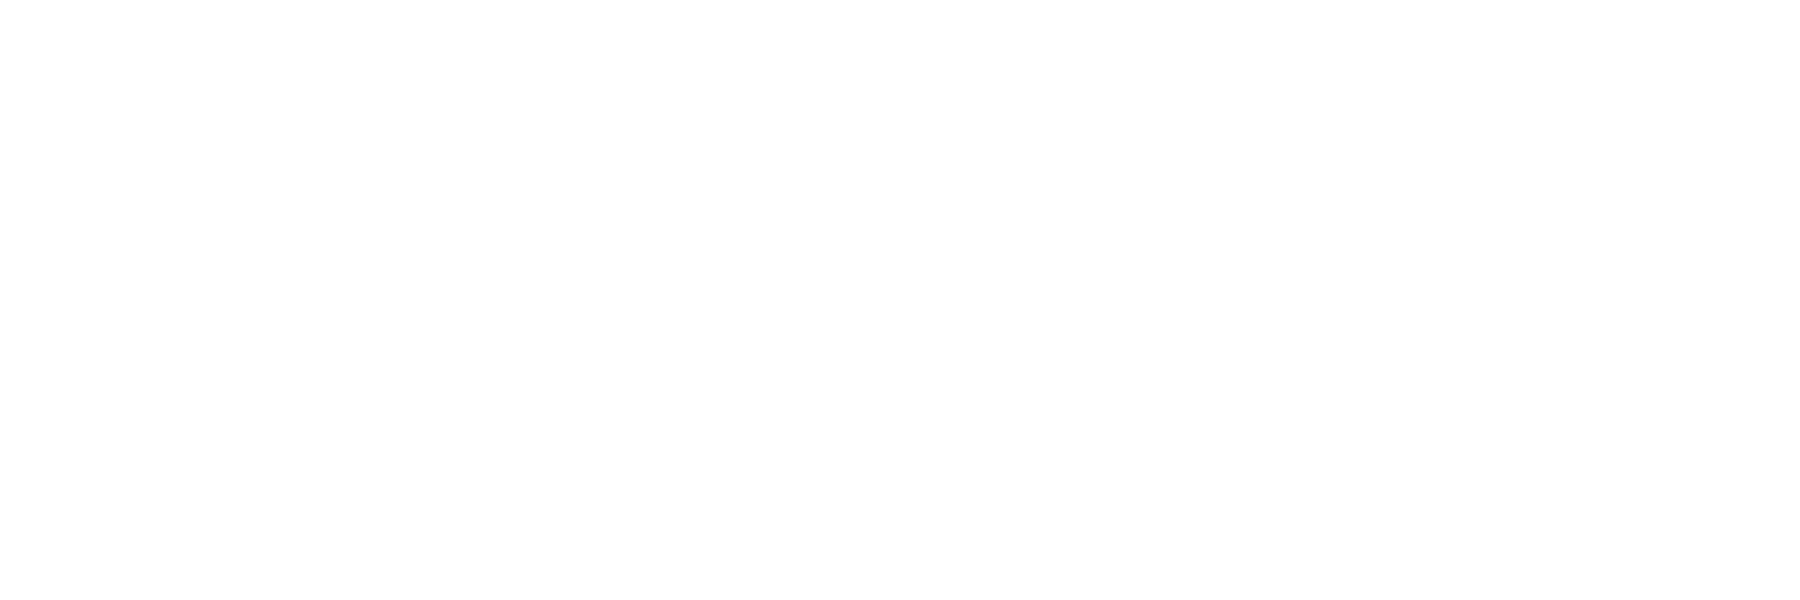

0.2758283549541605
1.3808880903320937


In [65]:

fig, ax = plt.subplots(figsize=(18,6))

#optical
optspec = specs_22jli['dbsp0820']['spec_photcal']
xs = optspec[:,0]/(1+z_22jli)
ys = optspec[:,1]

xs_new, ys_new = spectrum_extinction_effect(xs, ys, -EBV, extmodel='gal3', compare_display=False)
ax.plot(xs, ys, alpha=0.1)
ax.plot(xs_new, ys_new, 'b')


opt_w1 = 3750
opt_w2 = 9150
mask = (xs_new>opt_w1)*(xs_new<opt_w2)
opt = trapz(ys_new[mask], x=xs_new[mask]) ##to get the correction factor for the NIR light 

#nir
fire_spec_0825_tellcorr = np.loadtxt('../data/spectra/FIRE/SN2022jli_FIRE_20220825_tellcorr.txt')

xs = fire_spec_0825_tellcorr[:,0]/(1+z_22jli)
ys = fire_spec_0825_tellcorr[:,1]*0.043
xs_new, ys_new = spectrum_extinction_effect(xs, ys, -EBV, extmodel='gal3', compare_display=False)
ax.plot(xs, ys, 'r--', alpha=0.1)
ax.plot(xs_new, ys_new, 'r', label='SN2022jli NIR')


nir_w1 = 9150
nir_w2 = 25000
mask = (xs_new>nir_w1)*(xs_new<nir_w2)
nir = trapz(ys_new[mask], x=xs_new[mask])

ax.fill_between([opt_w1, opt_w2], [1.1e-14, 1.1e-14], [0, 0], alpha=0.2, color='c', edgecolor='none')
ax.fill_between([nir_w1, nir_w2], [7e-15, 7e-15], [0, 0], alpha=0.2, color='r', edgecolor='none')
ax.text(6548, 7.5e-15, 'optical', rotation=0, ha='center')
ax.text(15000, 3.5e-15, 'NIR', rotation=0, ha='center')
ax.set_title("nir/(opt+nir) = %s"%np.round(nir/(opt+nir), 3))

print(nir/(opt+nir))
print((nir+opt)/opt)

ax.set_xlim([2500, 25200])
ax.set_ylim([-1e-19, 1.2e-14])

bc_phase.append(107)
bc_nir_frac.append(nir/(opt+nir))



#### +224d 

<IPython.core.display.Javascript object>


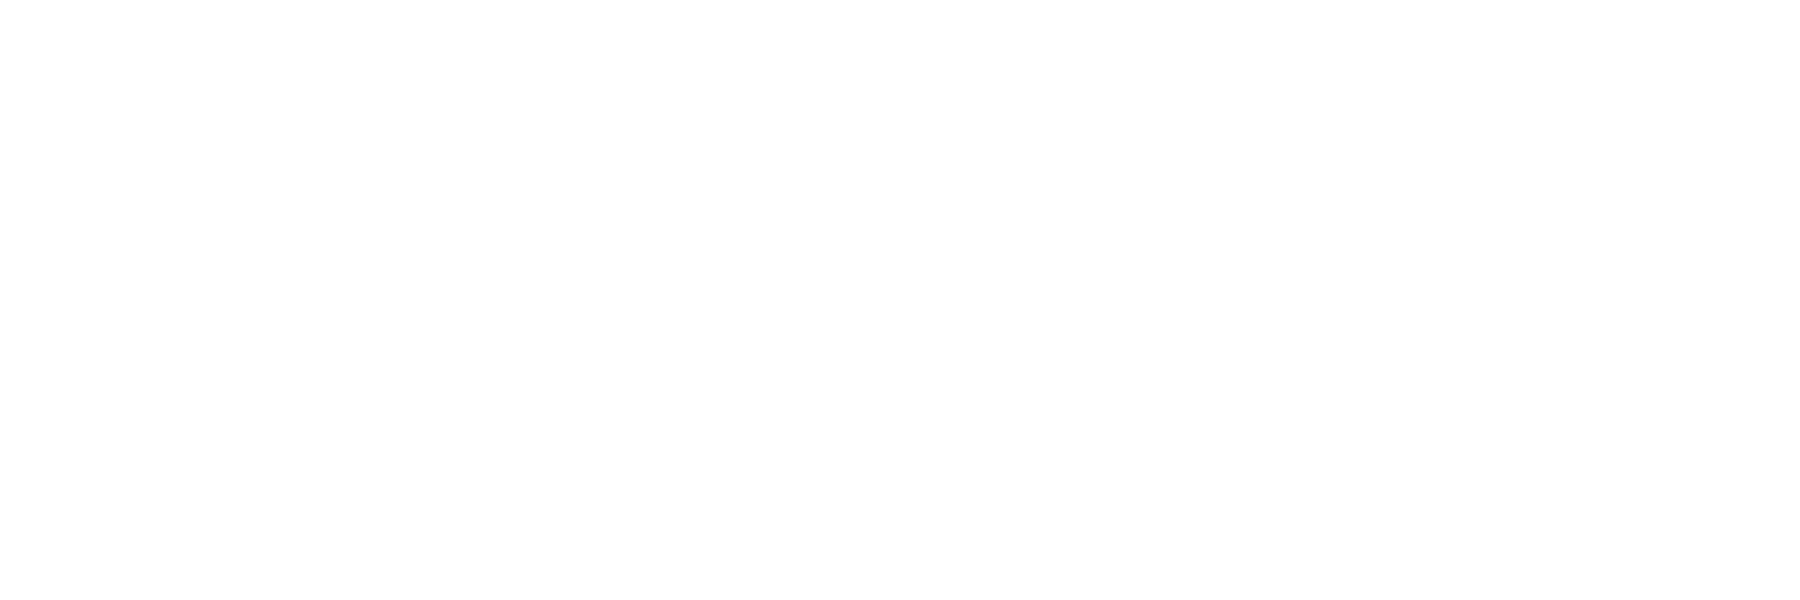

0.28755825138029456
1.4036235270285802


In [66]:
#NIR correction for the FIRE 12-14 epoch
fig, ax= plt.subplots(figsize=(18,6))


specname = 'binospec1227'  #
spec = specs_22jli[specname]['spec_photcal']
xs = spec[:,0]
ys = spec[:,1]

xs_new, ys_new = spectrum_extinction_effect(xs, ys, -EBV, extmodel='gal3', compare_display=False)
ax.plot(xs, ys, 'b--', alpha=0.1)
ax.plot(xs_new, ys_new, 'b', label='binospec1227')


opt_w1 = 3750
opt_w2 = 9150
mask = (xs_new>opt_w1)*(xs_new<opt_w2)
opt = trapz(ys_new[mask], x=xs_new[mask]) ##to get the correction factor for the NIR light 


spec =  np.loadtxt('../data/spectra/magellan_fire_20221214/SN2022jli_FIRE_20221214.txt')
xs = spec[:,0]
ys = spec[:,1]*1.1e-18
xs_new, ys_new = spectrum_extinction_effect(xs, ys, -EBV, extmodel='gal3', compare_display=False)

ax.plot(xs, ys, 'r--', alpha=0.1)

mask = (xs>13500)*(xs<14200)
ys_new[mask] = 1e-16

mask = (xs>18200)*(xs<19300)
ys_new[mask] = 1.0e-16

mask = (xs>24700)*(xs<25200)
ys_new[mask] = 1e-16

ax.plot(xs_new, ys_new, 'r', alpha=1)

ax.set_xlim([2500, 25200])
ax.set_ylim([-4e-17, 3.2e-15])

nir_w1 = 9150
nir_w2 = 25000
mask = (xs_new>nir_w1)*(xs_new<nir_w2)
nir = trapz(ys_new[mask], x=xs_new[mask])



ax.fill_between([opt_w1, opt_w2], [1.1e-14, 1.1e-14], [0, 0], alpha=0.2, color='c', edgecolor='none')
ax.fill_between([nir_w1, nir_w2], [7e-15, 7e-15], [0, 0], alpha=0.2, color='r', edgecolor='none')
ax.text(6548, 2.5e-15, 'optical', rotation=0, ha='center')
ax.text(15000, 1.5e-15, 'NIR', rotation=0, ha='center')
ax.set_title("nir/(opt+nir) = %s"%np.round(nir/(opt+nir), 3))

# print(nir)
# print(opt)

print(nir/(opt+nir))
print((nir+opt)/opt)



bc_phase.append(224)
bc_nir_frac.append(nir/(opt+nir))


In [67]:
bc_corr_table  = np.array([bc_phase, bc_nir_frac]).transpose()
np.savetxt('../data/bolometric_light_curve/SN2022jli_BC_data.txt', bc_corr_table)

##  build the bolometric light curve

<IPython.core.display.Javascript object>


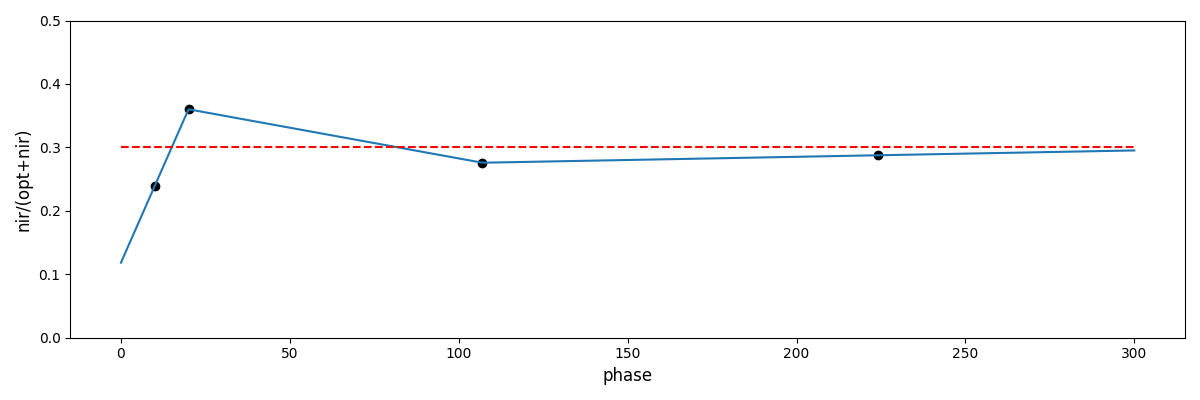

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


        jd           G    eG  binepoch_G ... binepoch_o   r      er  binepoch_r
------------------ ----- ---- ---------- ... ---------- ------ ----- ----------
 4.669999999925494   nan  nan          0 ...          0    nan   nan          0
 5.660000000149012   nan  nan          0 ...          0    nan   nan          0
 8.915370000060648   nan  nan          0 ...          0    nan   nan          0
10.660000000149012   nan  nan          0 ...          0    nan   nan          0
 11.32395499991253 14.61 0.05          1 ...          0    nan   nan          0
 11.32395499991253  14.6 0.05          1 ...          0    nan   nan          0
12.661079999990761   nan  nan          0 ...          0    nan   nan          0
14.677469999995083   nan  nan          0 ...          0    nan   nan          0
 16.66923000011593   nan  nan          0 ...          0    nan   nan          0
21.669999999925494   nan  nan          0 ...          0    nan   nan          0
               ...   ...  ...        ...

<IPython.core.display.Javascript object>


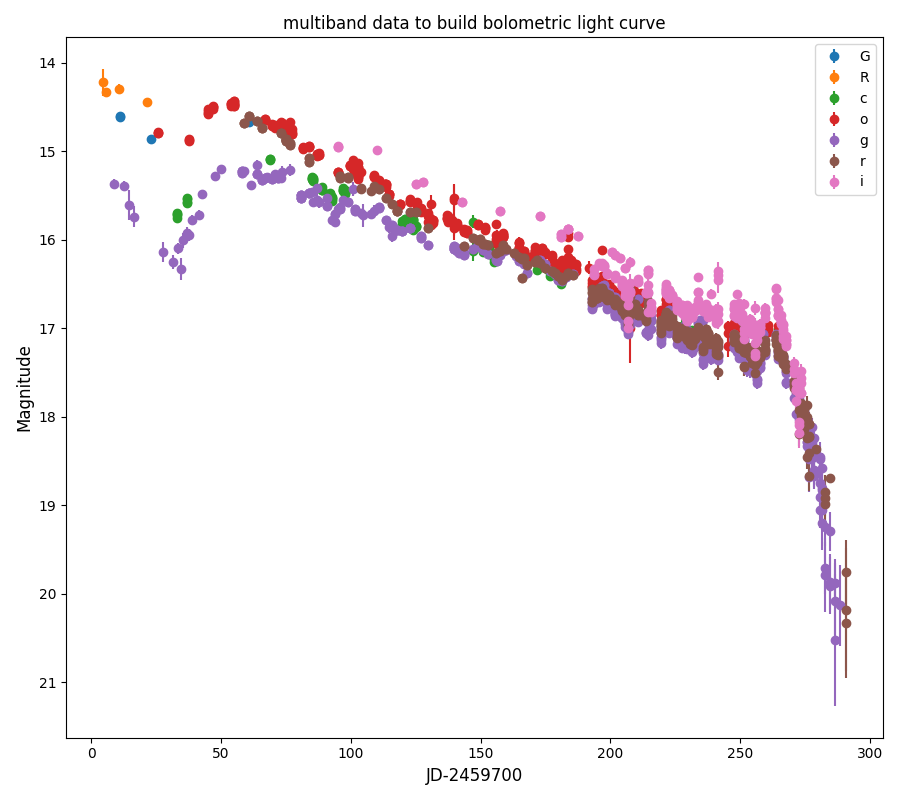

<IPython.core.display.Javascript object>


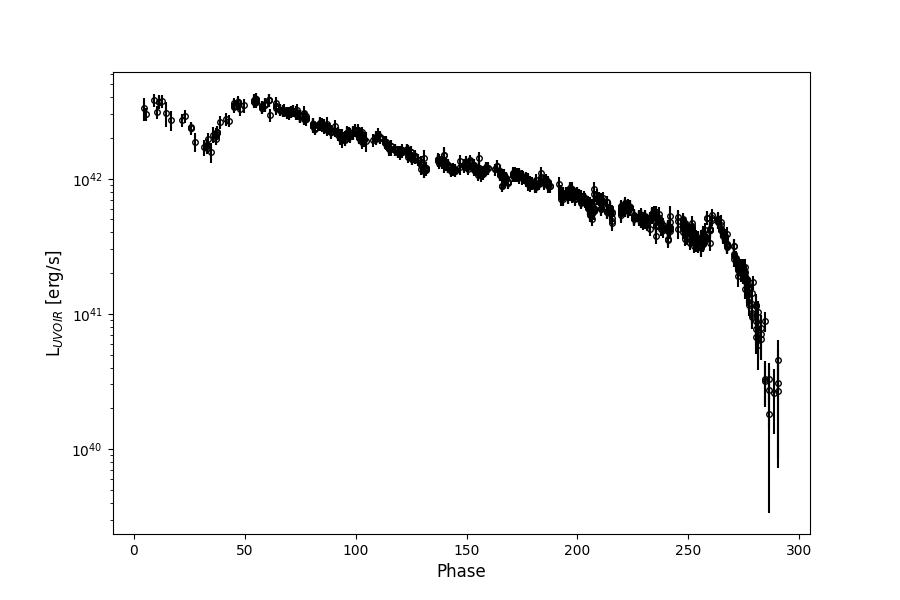

Text(0, 0.5, 'L$_{UVOIR}$ [erg/s]')

In [106]:
#remove those which are not used for building L_bol

spectable = spectable[spectable['specname']!='psh0511']
spectable = spectable[spectable['specname']!='imacs1214']
spectable = spectable[spectable['specname']!='efosc1223']
spectable = spectable[spectable['specname']!='sedm0202']
#spectable = spectable[spectable['specname']!='xsh0114']
#spectable


########## get Bolometric correction data
bc_data = np.loadtxt('../data/bolometric_light_curve/SN2022jli_BC_data.txt')

fig, ax = plt.subplots(figsize =(12,4))
ax.plot(bc_data[:,0], bc_data[:,1], 'ko')
ax.set_ylim([0, 0.5])

bc_model = interp1d(bc_data[:,0], bc_data[:,1], kind='linear', bounds_error=False, fill_value='extrapolate')
ax.plot(np.linspace(0, 300, 300), bc_model(np.linspace(0, 300, 300)))
ax.hlines(0.3, xmin=0, xmax=300, linestyles='dashed', colors='red')

ax.set_xlabel('phase', fontsize=12)
ax.set_ylabel("nir/(opt+nir)", fontsize=12)
plt.tight_layout()



######## get the magnitude table 

lctable = Table.read('../data/bolometric_light_curve/sn2022jli_photometry_data_allbands_no_extinction_corrected.csv', format='ascii.csv')  ## lctable column 'jd' is phase relative to JD=2459700

magpd, magtable = get_mag_table(lctable, bands=None, bandcolname='flt', obstimecolname='phase', calmagcol='mag', calmagerrcol='magerr', instmagerrcol='magerr', dt=1.0, outfile=None, binning=False)

magtable
magtable.write('../data/bolometric_light_curve/SN2022jli_magtable.csv',format='ascii', overwrite=True)

magtable = Table.read('../data/bolometric_light_curve/SN2022jli_magtable.csv',format='ascii')
print(magtable)

#de
mask = (magtable['jd']> 23.02)*(magtable['jd']<23.023)
magtable = magtable[~mask]


print(magtable.colnames)

fig, ax = plt.subplots(figsize=(9,8))

for flt in ['G','R','c','o','g','r','i']:
    #fltdata = 
    ax.errorbar(magtable['jd'], magtable[flt], yerr=magtable['e'+flt], fmt='o', label=flt)
    
ax.legend(loc=0)
ax.invert_yaxis()

ax.set_xlabel('JD-2459700', fontsize=12)
ax.set_ylabel('Magnitude', fontsize=12)
ax.set_title('multiband data to build bolometric light curve')
plt.tight_layout()
#plt.savefig('../plots/sn2022jli_lcs_all_for_bol.pdf')



##### get the optical wavelength luminosity

D = 22.5*1e6 #pc
tmaxg_22jli = 2459700  #abitrary def used for phase of light curve data
t0_22jli = 2459704.67 # discovery time 2022-05-05T04:04:48.00 by Libert Monard see https://www.wis-tns.org/object/2022jli

fint_opt = []
fint_opt_err = []


opt_w1 = 3750
opt_w2 = 9150

for i, phot in enumerate(magtable):
    #if i>2:
    #    continue
    phase = phot['jd'] + tmaxg_22jli - t0_22jli # get the phase of the phot point in the spectral reference system 
    temp = np.absolute(spectable['phase'] - phase)

    specname = spectable['specname'][np.argsort(temp)[0]]
    specphase = spectable['phase'][np.argsort(temp)[0]]
    
    #print(phase, specphase)

    spec = specs_22jli[specname]
    if 'spec_photcal' in spec.keys():
        specdata = spec['spec_photcal']
    else:
        specdata = spec['spec']

        
    flts = []
    mags = []
    magserr =[]
    magssys = []
    for flt in ['R', 'G', 'c', 'o', 'g', 'r', 'i']:
        if not np.isnan(phot[flt]):
            flts.append(flt)
            mags.append(phot[flt])
            magserr.append(phot['e'+flt])
            if flt == 'R':
                magssys.append('Vega') 
            else:
                magssys.append('AB') 
    
    #print(flts, mags, magserr, magssys)
    magtable_epoch = Table([flts, mags, magserr, magssys], names=['flt', 'mag', 'magerr' ,'sys'])
    magtable_epoch = magtable_epoch[magtable_epoch['mag']!=0]
    #print(magtable)
    
    abmag_table = get_SED_AB_mag(magtable_epoch, target_name='2022jli', A_V=None, correct_gal_extinction=False)
    polyfunc, polyobj = spectrum_flux_calibrate(specdata, filter_curves,  flts, abmag_table, polyorder=0, display=0)
    specdata[:,1] = polyfunc(polyobj.params, specdata[:,0])*specdata[:,1]
    
    xs = specdata[:,0]
    ys = specdata[:,1]
    
    
    ##generate middle product for diagnosis
    sed_flux_table = get_SED_flux(abmag_table, waveeff_dict= None)
    phase_filename = str(phot['jd'])
    sed_flux_table.write('../data/bolometric_light_curve/build_Lbol/sedflux_%s.txt'%phase_filename, format='ascii.csv', overwrite=1)
    np.savetxt('../data/bolometric_light_curve/build_Lbol/spec_%s.txt'%phase_filename, specdata)

    xs_new, ys_new = spectrum_extinction_effect(xs, ys, -EBV, extmodel='gal3', compare_display=False)
    mask = (xs_new>opt_w1)*(xs_new<opt_w2)
    opt = trapz(ys_new[mask], x=xs_new[mask])
    #print(opt)
    
    fint_opt.append(opt)
    fint_opt_err.append(np.mean(magserr))
    
#### apply NIR correction: nir/(nir+opt) = BC --> 1-opt/(nir+opt) = BC --> opt+nir  = opt/(1-BC)

#fint= fint_opt/(1-bc_model(magtable['jd']))
fint = np.array(fint_opt)/(1-0.3) #in the end apply NIR fraction of 0.3 and add 10% uncertainty to the total integrated flux

L = 4*np.pi* (constants.pc.to('cm').value*D)**2*np.array(fint)
Lerr = L* np.sqrt( (1.086*np.array(fint_opt_err) )**2 + 0.1**2)  #could be improved



##### show the bolometric light curve
fig, ax = plt.subplots(figsize=(9,6))

ax.errorbar(magtable['jd'], L, yerr=Lerr, fmt='ko', ms=4, mfc='none') 


Lbol = Table([magtable['jd'], L, Lerr], names=['phase', 'L', 'eL']) ## phase is days after JD=2459700
Lbol.write('../data/bolometric_light_curve/SN2022jli_bolometric_LC_20230301.csv', format='ascii.csv', overwrite=1)

ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('Phase', fontsize=12)
ax.set_ylabel(r'L$_{UVOIR}$ [erg/s]', fontsize=12)

## some analysis on the bolometric light curve

In [199]:
from PyAstronomy import funcFit as fuf
import emcee
from scipy import signal

In [202]:
def construct_emperical_bump_model(x, P, rise, height, xshift, yshift, win_sigma, tbin=0.1):
    #decline = P - rise
    #height = 1
    
    Ncycle = 3
    tbin = 0.1
    Npoint = int(P/tbin)*Ncycle
    ts = np.linspace(0, Ncycle*P,  Npoint)   
    sig = np.zeros_like(ts)
    sig0 = np.append(ts[ts<rise]*height/rise, -height/(P-rise)*(ts[(ts>rise)*(ts<P)]-P))
    for i in range(Ncycle):
        sig[(ts>=i*P)*(ts<=(i+1)*P)] = sig0

    
    win = signal.windows.gaussian(int(P/tbin), np.absolute(win_sigma)/tbin)
    filtered = signal.convolve(sig, win, mode='same') / sum(win)
    
    filteredtemp = filtered[(ts>(P-3))*(ts< (P+3) )]
    tstemp = ts[(ts>(P-3))*(ts< (P+3) )]
    t1 = tstemp[filteredtemp == np.min(filteredtemp)]
    filteredtemp = filtered[(ts>(2*P-3))*(ts< (2*P+3) )]
    tstemp = ts[(ts>(2*P-3))*(ts< (2*P+3) )]
    t2 = tstemp[filteredtemp == np.min(filteredtemp)]
    
    sigfiltered = filtered[(ts>= (t1+xshift) )*(ts< (t2+xshift) )]
        
    
    model = interp1d( np.linspace(0, P, len(sigfiltered)), sigfiltered + yshift, kind='linear' )
    result = model(x)
    
    return result



def calculate_chi2(p, data):
    x, y, yerr = data
    P  = 12.37
    rise, height, xshift, yshift, sigma = p
    model = construct_emperical_bump_model(x, P, rise, height, xshift, yshift, sigma)
    chi2 = np.sum( (y-model)**2/yerr**2 )
    return chi2



class OneDFit2(fuf.OneDFit):
    def __init__(self, parlist):
        fuf.OneDFit.__init__(self, parlist)

    def evaluate(self, x):

        P = 12.37
        rise = self['rise']
        height = self['height']
        yshift = self['yshift']
        xshift = self['xshift']
        #tau = self['tau']    
        y = construct_emperical_bump_model(x, P, rise, height, xshift, yshift, win_sigma=0.2, tbin=0.1)
            
        return y
    
def corner_plot(mcmcdbfile, parslist=None):
    '''
        create the corner plot
        '''
    import os
    import corner

    if not os.path.exists(mcmcdbfile):
        raise ValueError("MCMC process database file %s not available" % self.param['mcmcdbfile'])
    ta = fuf.TraceAnalysis(mcmcdbfile)
    #burnnum = int(self.param['mcmcburnnum'])
    thin = 1
    ta.setBurn(0)
    ta.setThin(thin)
    if parslist is None:
        parslist = ta.availableParameters()
    data = np.array([ta[par] for par in parslist]).transpose()
    figure = corner.corner(data, bins=20, show_titles=False, quantiles=[0.16, 0.5, 0.84], levels=[0.393, 0.865, 0.989], labels=parslist)  # the adoption of levels is not well understood...to check
    figure.show()

<IPython.core.display.Javascript object>


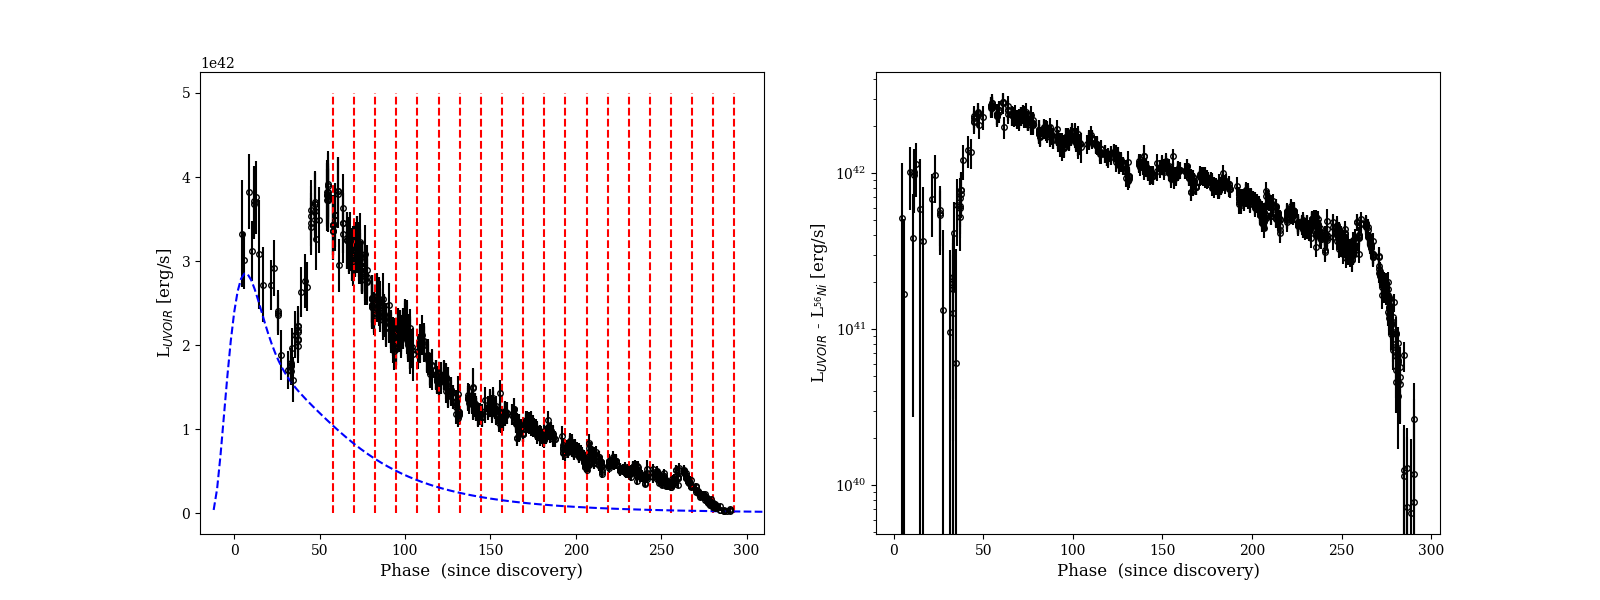

Text(0, 0.5, 'L$_{UVOIR}$ - L$_{^{56}Ni}$ [erg/s]')

In [302]:
Lbol = Table.read('../data/bolometric_light_curve/SN2022jli_bolometric_LC_20230301.csv', format='ascii.csv')


fig, (ax, ax2) = plt.subplots(1,2, figsize=(16,6))

ax.errorbar(Lbol['phase'], Lbol['L'], yerr=Lbol['eL'], fmt='ko', ms=4, mfc='none')
ax.vlines(-4+np.arange(5,25)*12.37, ymin=1e39, ymax=5e42, linestyles='dashed', colors='red')  #The vertical lines mark the minima of the undulations

Lni56 = Table.read('../data/bolometric_light_curve/sn2022jli_Lbol_Ni56_modeldata.csv', format='ascii.csv')

ax.plot(Lni56['phase']-13, Lni56['L2'], 'b--', label=r'0.15 M$_\odot$ $^{56}$Ni')

Lni56_model = interp1d(Lni56['phase']-13, Lni56['L2'], kind='linear')
ax2.errorbar(Lbol['phase'], Lbol['L']-Lni56_model(Lbol['phase']), yerr=Lbol['eL'], fmt='ko', ms=4, mfc='none')


ax.set_xlim([-20, 310])
ax.set_xlabel('Phase  (since discovery)', fontsize=12)
ax.set_ylabel(r'L$_{UVOIR}$ [erg/s]', fontsize=12)

ax2.set_yscale('log')
ax2.set_xlabel('Phase  (since discovery)', fontsize=12)
ax2.set_ylabel(r'L$_{UVOIR}$ - L$_{^{56}Ni}$ [erg/s]', fontsize=12)


[-0.5207351148133538, 0.04387006488042226, -0.0009076611412742323, 8.803540564886185e-06, -4.462626908413156e-08, 1.1425398281168732e-10, -1.1670139992802834e-13]
255.76999999999998 268.14


<IPython.core.display.Javascript object>


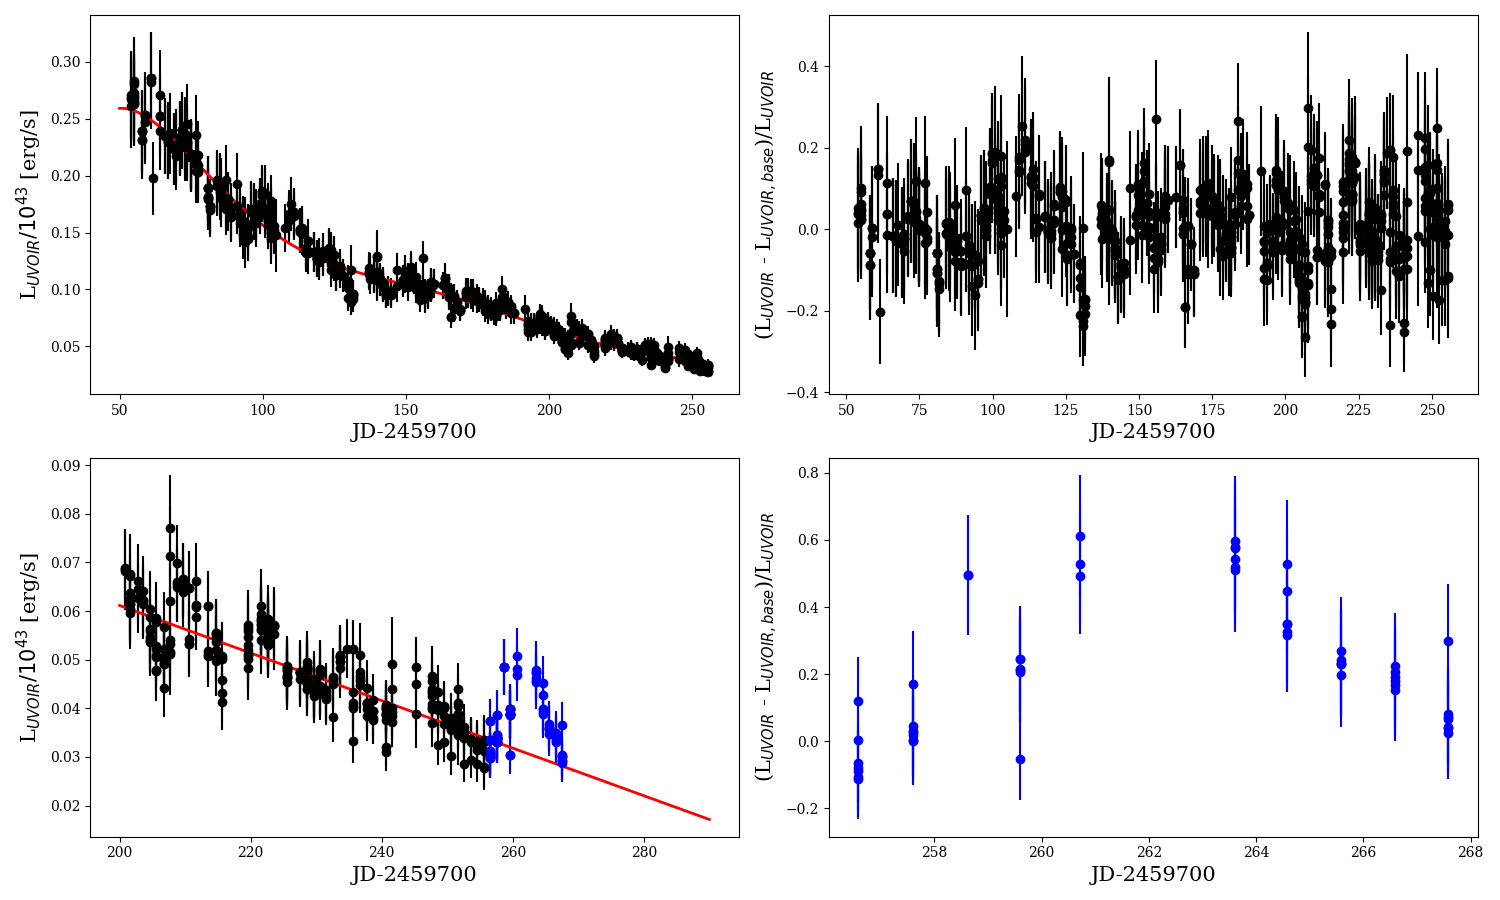

In [362]:

polyorder = 6
polyfunc1 = poly6    

xs = Lbol['phase']
ys = Lbol['L']/1e43 - Lni56_model(xs)/1e43
yserr = yerr=Lbol['eL']/1e43


xmin = 50
xmax = 256
fitrange = (xs> xmin)*(xs<xmax)
xsfit = xs[fitrange]
ysfit = ys[fitrange]
yerrsfit = yserr[fitrange]
fitobj1 = polyfit(xsfit, ysfit, yerrsfit, polyorder)
xsmodel = np.linspace(xmin, xmax, 1000)
ysmodel = polyfunc1(fitobj1.params, xsmodel)
ys_fitret = polyfunc1(fitobj1.params, xsfit)
print(fitobj1.params)

np.savetxt('../data/bolometric_light_curve/Lbol_relative_undulation.txt', np.array([xsfit, (ysfit-ys_fitret)/ys_fitret, yerrsfit/ys_fitret]).transpose())

polyorder2 = 1
polyfunc2 = poly1  
fitrange = (xs> 200)*(xs<260)
xsfit2 = xs[fitrange]
ysfit2 = ys[fitrange]
yerrsfit2 = yserr[fitrange]
fitobj2 = polyfit(xsfit2, ysfit2, yerrsfit2, polyorder2)
xsmodel2 = np.linspace(200, 290, 100)
ysmodel2 = polyfunc2(fitobj2.params, xsmodel2)



lastx1 = -4+21*12.37
lastx2 = -4+22*12.37
print(lastx1, lastx2)
lastxs = xs[(xs>lastx1)*(xs<lastx2)]
lastys = ys[(xs>lastx1)*(xs<lastx2)]
lastyserr = yserr[(xs>lastx1)*(xs<lastx2)]

ys_fitret_last = polyfunc2(fitobj2.params, lastxs)
np.savetxt('../data/bolometric_light_curve/Lbol_relative_undulation_lastbump_before_phase3.txt', np.array([lastxs, (lastys-ys_fitret_last)/ys_fitret_last, lastyserr/ys_fitret_last]).transpose())


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,9))

ax1.errorbar(xsfit, ysfit, yerr=yerrsfit, fmt='ko')
ax1.plot(xsmodel, ysmodel, 'r', lw=2)
ax1.set_xlabel('JD-2459700', fontsize=15)
ax1.set_ylabel(r'L$_{UVOIR}/10^{43}$ [erg/s]', fontsize=15)

data1 = np.loadtxt('../data/bolometric_light_curve/Lbol_relative_undulation.txt')
ax2.errorbar(data1[:,0], data1[:,1], yerr=data1[:,2], fmt='ko')
ax2.set_xlabel('JD-2459700', fontsize=15)
ax2.set_ylabel(r'(L$_{UVOIR}$ - L$_{UVOIR, base}$)/L$_{UVOIR}$', fontsize=15)

ax3.errorbar(xsfit2, ysfit2, yerr=yerrsfit2, fmt='ko')
ax3.errorbar(lastxs, lastys, yerr=lastyserr, fmt='bo')
ax3.plot(xsmodel2, ysmodel2, 'r', lw=2)
ax3.set_xlabel('JD-2459700', fontsize=15)
ax3.set_ylabel(r'L$_{UVOIR}/10^{43}$ [erg/s]', fontsize=15)

data2 = np.loadtxt('../data/bolometric_light_curve/Lbol_relative_undulation_lastbump_before_phase3.txt')
ax4.errorbar(data2[:,0], data2[:,1], yerr=data2[:,2], fmt='bo')
ax4.set_xlabel('JD-2459700', fontsize=15)
ax4.set_ylabel(r'(L$_{UVOIR}$ - L$_{UVOIR, base}$)/L$_{UVOIR}$', fontsize=15)

plt.tight_layout()

starting point for sampling: {'rise': 2.5, 'height': 0.15, 'xshift': 4, 'yshift': -0.06}


EMCEE progress: 100% |/                                        | ETA:  00:00:00

Lowest deviance set:  {'rise': 2.1560790725303476, 'height': 0.1853196397262096, 'xshift': 4.001172370758587, 'yshift': -0.08600219695716109}
  at chain index:  270692
Set of mean values:  {'rise': 2.2257782989233594, 'height': 0.18545765318527344, 'xshift': 4.008614153283261, 'yshift': -0.08591114144871147}
Set of median values:  {'rise': 2.2257782989233594, 'height': 0.18545765318527344, 'xshift': 4.008614153283261, 'yshift': -0.08591114144871147}
rise uncertainty: (1.9146848465553812, 2.5007488393316293) 0.3021123011580837
---------------------------------
Parameters for Component: unnamed
---------------------------------
Parameter:   rise  , [  rise], value:      2.15608, free:  True, restricted: False, related: False
Parameter: height  , [height], value:      0.18532, free:  True, restricted: False, related: False
Parameter: xshift  , [xshift], value:      4.00117, free:  True, restricted: False, related: False
Parameter: yshift  , [yshift], value:   -0.0860022, free:  True, rest

<IPython.core.display.Javascript object>


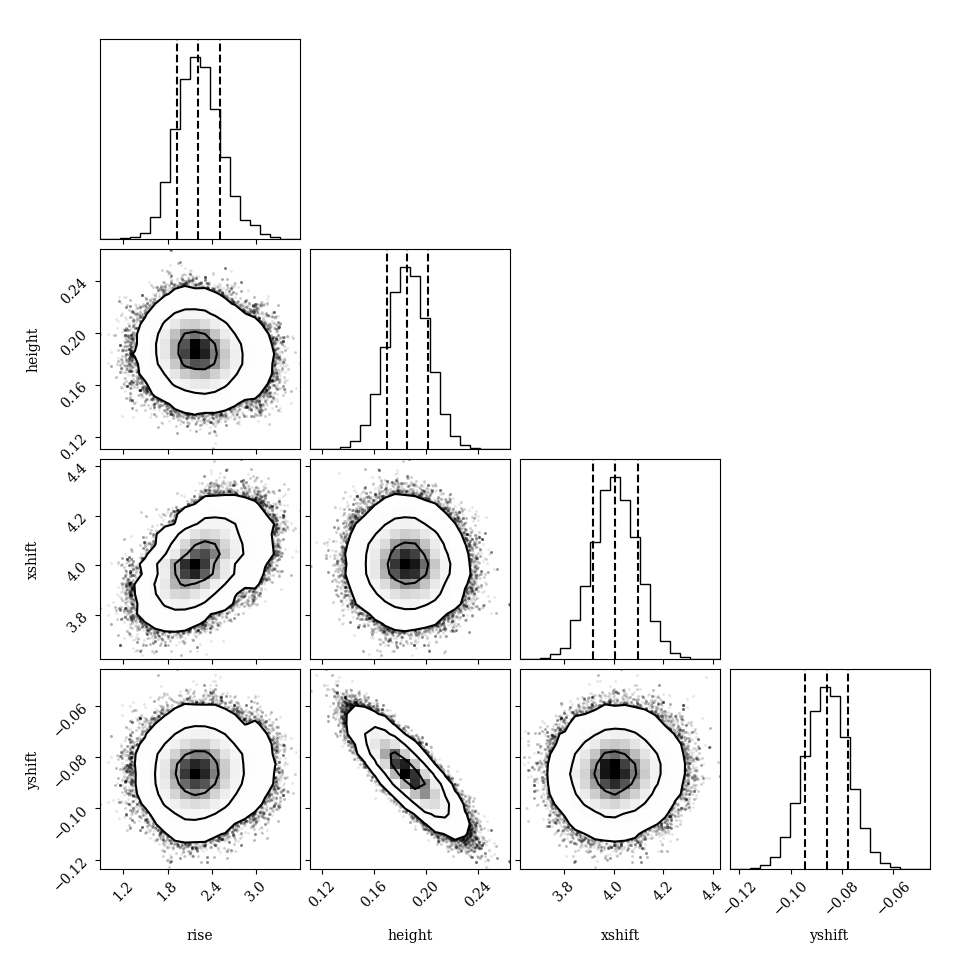

<IPython.core.display.Javascript object>


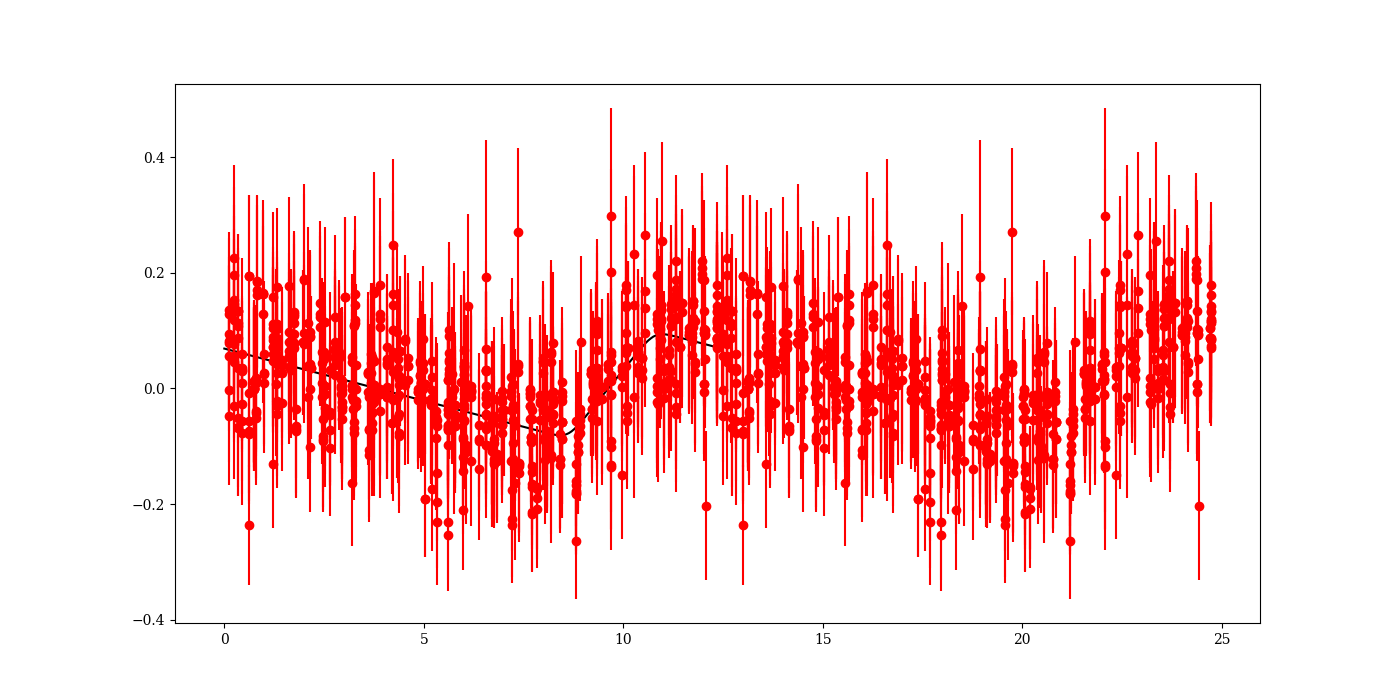

chi2 best fit: 258.3938384139894


<IPython.core.display.Javascript object>


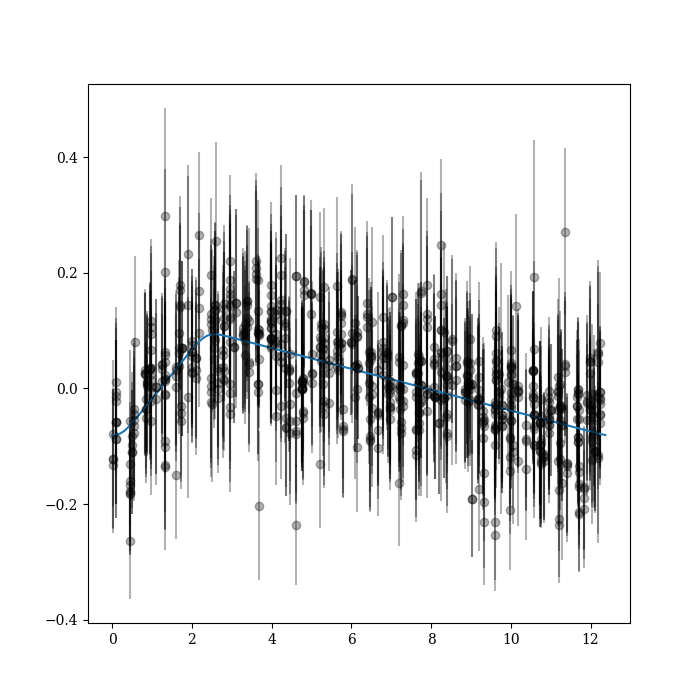

The rise phase duration: 
[2.54859296]


In [363]:

dbfile = "../calculation_output/undulation_profile_emcee/Lbol_undulation_profile_mcmc_fitret_tmp.emcee"
refit = 0
show_corner_plot = 1
show_deviance = 0

parlist = ['rise', 'height', 'xshift', 'yshift']
params0 = {'rise': 2.5, 'height':0.15, 'xshift':4, 'yshift':-0.06}
fminfit = OneDFit2(parlist)


period = 12.37

Lbol_delta = np.loadtxt('../data/bolometric_light_curve/Lbol_relative_undulation.txt')

xs = Lbol_delta[:,0]   #obsJD - 2459700    
ys = Lbol_delta[:,1]
yerrs = Lbol_delta[:,2]
phases = (xs%period)/period

xfit = phases*period
yfit = ys
yerrfit = yerrs


for i,parname in enumerate(parlist):
    fminfit[parname] = params0[parname]


if (not os.path.exists(dbfile)) or refit:
    if os.path.exists(dbfile):
        os.remove(dbfile)

    priors = {}

    parname = 'rise'
    #prior = fuf.FuFPrior("limuniform", lower= -0.5, upper=-0.1) 
    prior = fuf.FuFPrior("gaussian", sig= 0.5, mu=params0[parname])
    priors[parname] = prior

    parname = 'height'
    #prior = fuf.FuFPrior("limuniform", lower= 0.1, upper=0.2) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'xshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'yshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    sampleArgs = {"iters": 50000, "burn": 10000}

    fminfit.thaw(parlist)
    X0 = fminfit.freeParameters()
    print("starting point for sampling:", X0)

    out = fminfit.fitEMCEE(xfit, yfit, yerr=yerrfit, sampleArgs=sampleArgs, priors=priors, dbfile=dbfile)


ta = fuf.TraceAnalysis(dbfile)
ta.setBurn(10000)


lds, index = ta.parameterSet(prescription="lowestDev")
print("Lowest deviance set: ", lds)
print("  at chain index: ", index)
means = ta.parameterSet(prescription="mean")
print("Set of mean values: ", means)
medians = ta.parameterSet(prescription="median")
print("Set of median values: ", means)


err_rise = ta.hpd('rise', cred=0.68)
err2_rise = ta.std('rise')
print('rise uncertainty:', err_rise, err2_rise)


### get the parameters with lowest deviance
for parname in parlist:
    fminfit[parname] = lds[parname]
    
fminfit.parameterSummary()

# corner plot
if show_corner_plot:
    corner_plot(dbfile)

# show the best-fit model
fig, ax = plt.subplots(figsize=(14,7))
P =12.37
xtemp = np.linspace(0, P, 200)
ax.plot(xtemp, fminfit.evaluate(xtemp), 'k')
ax.errorbar(phases*P, ys, yerr=yerrs, fmt='ro')
ax.errorbar(phases*P+P, ys, yerr=yerrs, fmt='ro')

#calculate chi2min
Lbol_params_lowestDEV = [lds['rise'], lds['height'],  lds['xshift'],  lds['yshift'], 0.2] 
fitdata = [xfit, yfit, yerrfit]
chi2min = calculate_chi2(Lbol_params_lowestDEV, fitdata)
print("chi2 best fit:", chi2min)

# deviance chain plot
if show_deviance:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(ta['deviance'])

## show the data and best-fit model in one period between two minima 
fig, ax = plt.subplots(figsize=(7,7))
xs = Lbol_delta[:,0]   #obsJD - 2459700    
ys = Lbol_delta[:,1]
yerrs = Lbol_delta[:,2]
Lbol_xshift = Lbol_params_lowestDEV[2]
ax.errorbar( (xs+Lbol_xshift)%period , ys, yerr=yerrs, fmt='ko', alpha=0.3)
xs_model = np.linspace(0, P, 200)
ys_model = construct_emperical_bump_model(xs_model, P, Lbol_params_lowestDEV[0], Lbol_params_lowestDEV[1], 0, Lbol_params_lowestDEV[3], Lbol_params_lowestDEV[4], tbin=0.1)
print('The rise phase duration: ')
print(xs_model[ys_model==np.max(ys_model)] - xs_model[ys_model==np.min(ys_model)])
ax.plot(xs_model, ys_model)

Lbol_model = interp1d(xs_model, ys_model, bounds_error = False, fill_value = 'extrapolate')



starting point for sampling: {'rise': 5, 'height': 0.6, 'yshift': -0.06}


EMCEE progress: 100% |/                                        | ETA:  00:00:00

Lowest deviance set:  {'rise': 6.449317461920178, 'height': 0.6872569249362225, 'yshift': -0.07305615172324928}
  at chain index:  41130
Set of mean values:  {'rise': 6.42412666320528, 'height': 0.6806319053090537, 'yshift': -0.07172101327063536}
Set of median values:  {'rise': 6.42412666320528, 'height': 0.6806319053090537, 'yshift': -0.07172101327063536}
rise uncertainty: (6.114193602199854, 6.803470737466603) 0.35781530389019145
---------------------------------
Parameters for Component: unnamed
---------------------------------
Parameter:   rise  , [  rise], value:      6.44932, free:  True, restricted: False, related: False
Parameter: height  , [height], value:     0.687257, free:  True, restricted: False, related: False
Parameter: xshift  , [xshift], value:            4, free: False, restricted: False, related: False
Parameter: yshift  , [yshift], value:   -0.0730562, free:  True, restricted: False, related: False


<IPython.core.display.Javascript object>


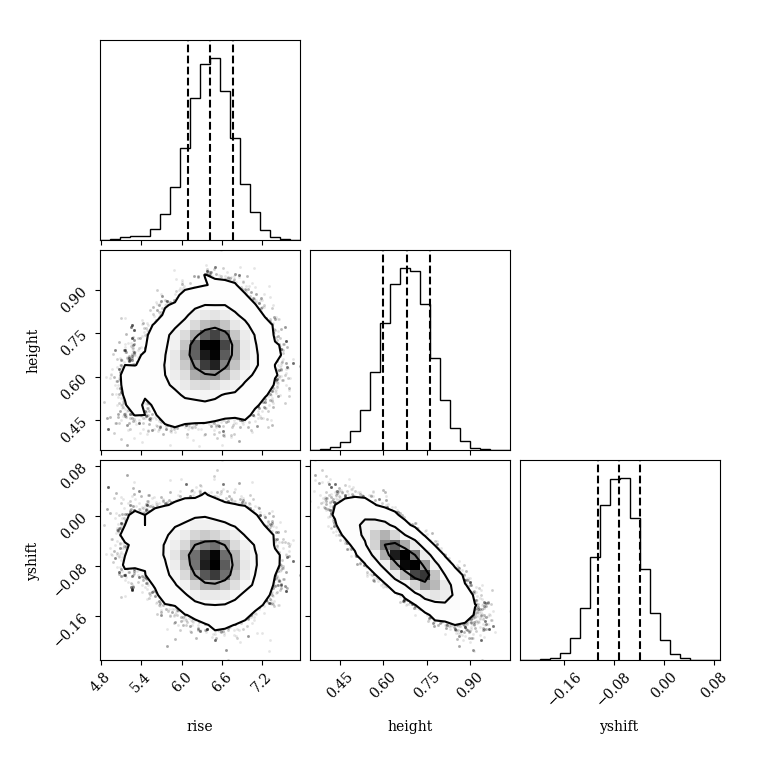

<IPython.core.display.Javascript object>


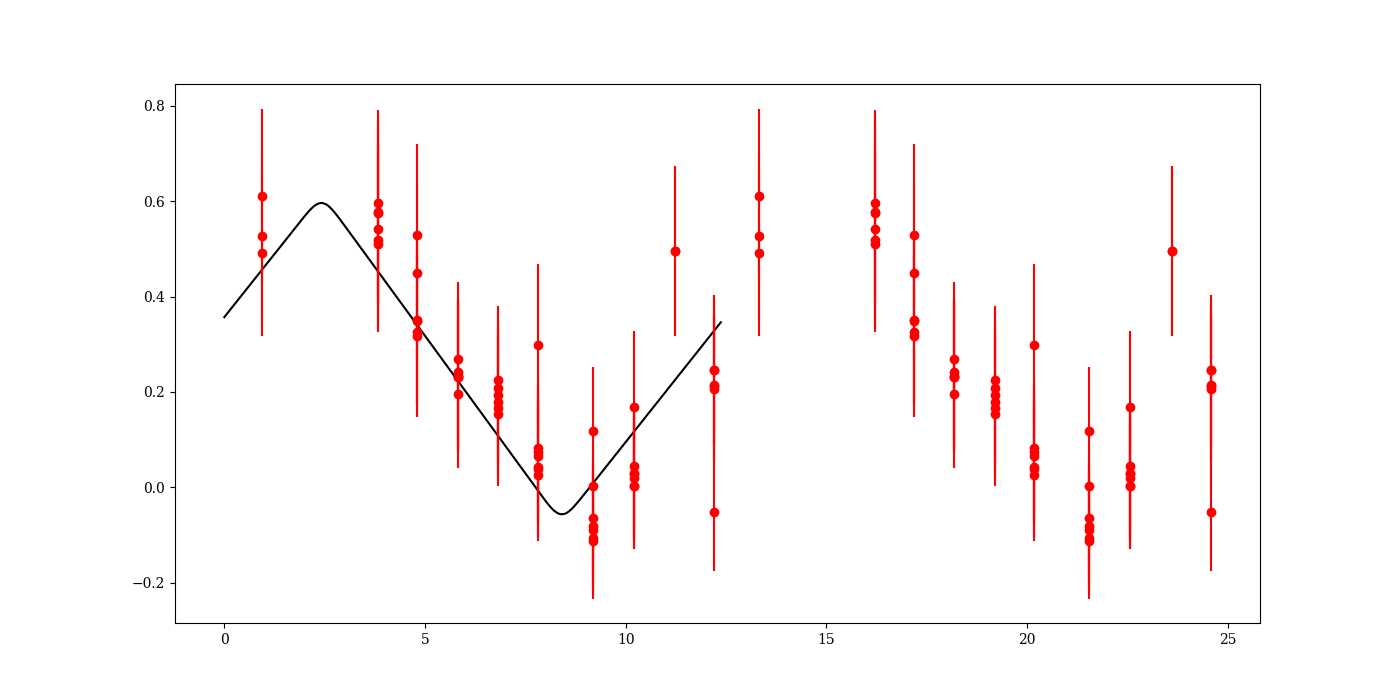

chi2 best fit: 34.272014157765305


<IPython.core.display.Javascript object>


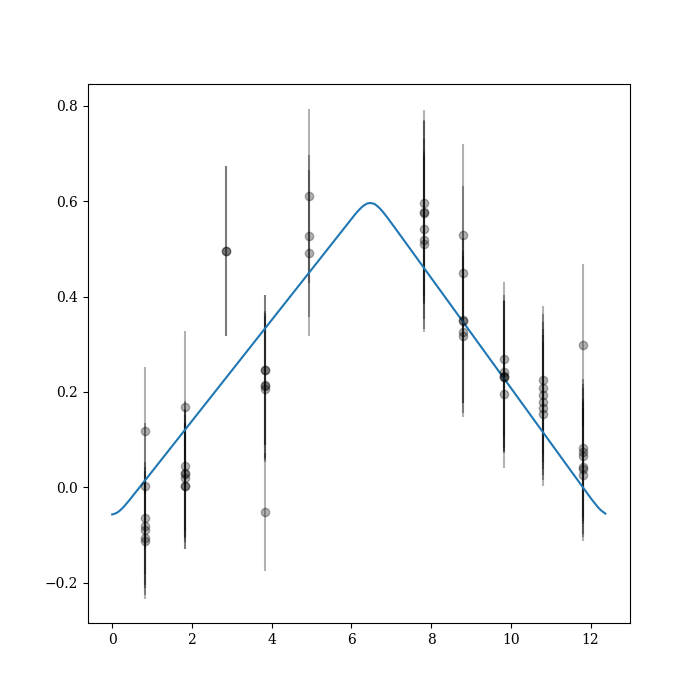

The rise phase duration: 
[6.46472362]


In [377]:

dbfile = "../calculation_output/undulation_profile_emcee/Lbol_lastbump_undulation_profile_mcmc_fitret_tmp.emcee"
refit = 1
show_corner_plot = 1
show_deviance = 0

parlist = ['rise', 'height', 'xshift', 'yshift']
params0 = {'rise': 5, 'height':0.6, 'xshift':4, 'yshift':-0.06}
fminfit = OneDFit2(parlist)

period = 12.37

Lbol_delta_last = np.loadtxt('../data/bolometric_light_curve/Lbol_relative_undulation_lastbump_before_phase3.txt')

xs = Lbol_delta_last[:,0]   #obsJD - 2459700    
ys = Lbol_delta_last[:,1]
yerrs = Lbol_delta_last[:,2]
phases = (xs%period)/period

xfit = phases*period
yfit = ys
yerrfit = yerrs


for i,parname in enumerate(parlist):
    fminfit[parname] = params0[parname]


if (not os.path.exists(dbfile)) or refit:
    if os.path.exists(dbfile):
        os.remove(dbfile)

    priors = {}

    parname = 'rise'
    #prior = fuf.FuFPrior("limuniform", lower= -0.5, upper=-0.1) 
    prior = fuf.FuFPrior("gaussian", sig= 0.5, mu=params0[parname])
    priors[parname] = prior

    parname = 'height'
    #prior = fuf.FuFPrior("limuniform", lower= 0.1, upper=0.2) 
    prior = fuf.FuFPrior("gaussian", sig= 0.2, mu=params0[parname])
    priors[parname] = prior

    parname = 'xshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    parname = 'yshift'
    #prior = fuf.FuFPrior("limuniform", lower= 0.5, upper=0.9) 
    prior = fuf.FuFPrior("gaussian", sig= 0.1, mu=params0[parname])
    priors[parname] = prior

    sampleArgs = {"iters": 20000, "burn": 3000}

    parlist_free = ['rise', 'height', 'yshift']
    
    fminfit.thaw(parlist_free)
    X0 = fminfit.freeParameters()
    print("starting point for sampling:", X0)

    out = fminfit.fitEMCEE(xfit, yfit, yerr=yerrfit, sampleArgs=sampleArgs, priors=priors, dbfile=dbfile)


ta = fuf.TraceAnalysis(dbfile)
ta.setBurn(10000)


lds, index = ta.parameterSet(prescription="lowestDev")
print("Lowest deviance set: ", lds)
print("  at chain index: ", index)
means = ta.parameterSet(prescription="mean")
print("Set of mean values: ", means)
medians = ta.parameterSet(prescription="median")
print("Set of median values: ", means)


err_rise = ta.hpd('rise', cred=0.68)
err2_rise = ta.std('rise')
print('rise uncertainty:', err_rise, err2_rise)


### get the parameters with lowest deviance
for parname in parlist_free:
    fminfit[parname] = lds[parname]
    
fminfit.parameterSummary()

# corner plot
if show_corner_plot:
    corner_plot(dbfile)

# show the best-fit model
fig, ax = plt.subplots(figsize=(14,7))
P =12.37
xtemp = np.linspace(0, P, 200)
ax.plot(xtemp, fminfit.evaluate(xtemp), 'k')
ax.errorbar(phases*P, ys, yerr=yerrs, fmt='ro')
ax.errorbar(phases*P+P, ys, yerr=yerrs, fmt='ro')

#calculate chi2min
last_params_lowestDEV = [lds['rise'], lds['height'],  4,  lds['yshift'], 0.2] 
fitdata = [xfit, yfit, yerrfit]
chi2min = calculate_chi2(last_params_lowestDEV, fitdata)
print("chi2 best fit:", chi2min)

# deviance chain plot
if show_deviance:
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(ta['deviance'])

## show the data and best-fit model in one period between two minima 
fig, ax = plt.subplots(figsize=(7,7))
xs = Lbol_delta_last[:,0]   #obsJD - 2459700    
ys = Lbol_delta_last[:,1]
yerrs = Lbol_delta_last[:,2]
last_xshift = last_params_lowestDEV[2]
ax.errorbar( (xs+ last_xshift)%period , ys, yerr=yerrs, fmt='ko', alpha=0.3)
xs_model = np.linspace(0, P, 200)
ys_model = construct_emperical_bump_model(xs_model, P, last_params_lowestDEV[0], last_params_lowestDEV[1], 0, last_params_lowestDEV[3], last_params_lowestDEV[4], tbin=0.1)
print('The rise phase duration: ')
print(xs_model[ys_model==np.max(ys_model)] - xs_model[ys_model==np.min(ys_model)])
ax.plot(xs_model, ys_model)

Lbol_model_last = interp1d(xs_model, ys_model, bounds_error = False, fill_value = 'extrapolate')



<IPython.core.display.Javascript object>


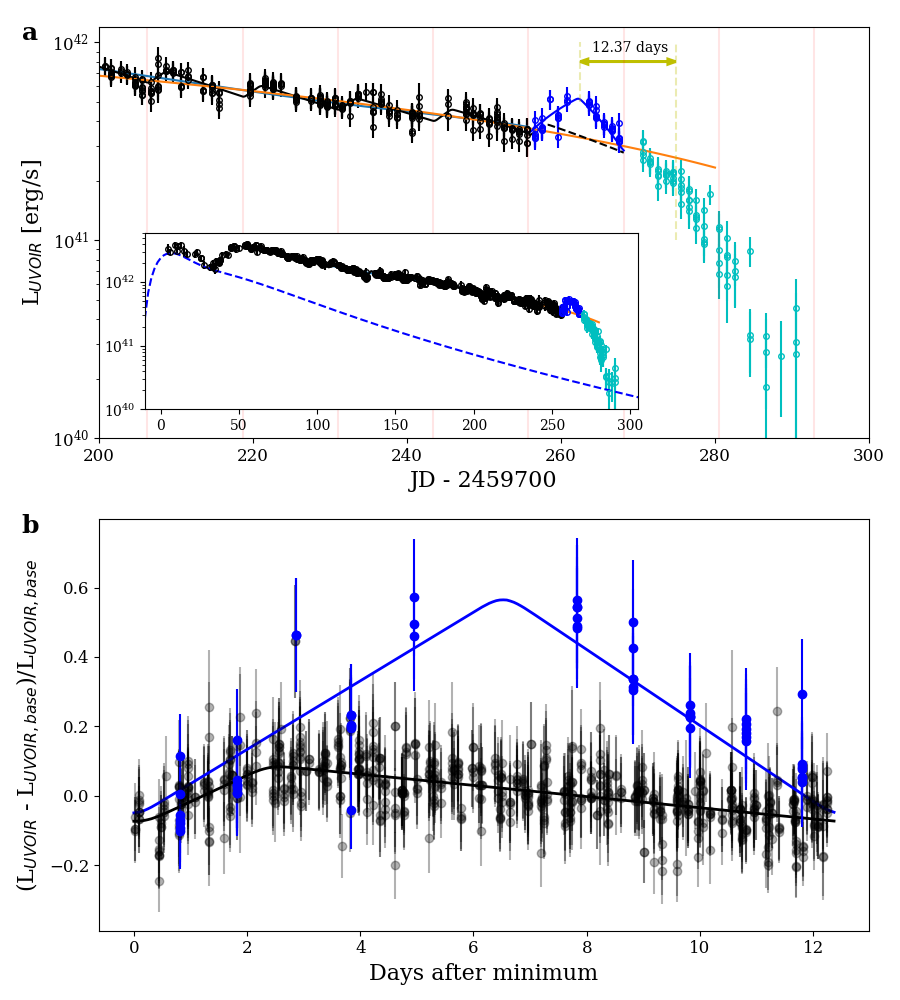

L excess: 9.004027518301228e+46
L_accretion_extrapolate: 3.2919831930476176e+47
L_accretion_obs 4.192385944877741e+47
L_accretion_excess: 9.004027518301235e+46


In [318]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'serif'


fig, (ax, ax2) = plt.subplots(2,1,figsize=(9,10), sharex=False)

axin = ax.inset_axes([0.06, 0.07, 0.64, 0.43])

mask1 = Lbol['phase']< (21*period-Lbol_xshift)
mask2 = (Lbol['phase']> (21*period-Lbol_xshift) )*(Lbol['phase']< (22*period-Lbol_xshift))
mask3 = Lbol['phase'] > (22*period-Lbol_xshift)

#axin.errorbar(Lbol['phase'], Lbol['L'], yerr=Lbol['eL'], fmt='ko', ms=4, mfc='none')
axin.errorbar(Lbol['phase'][mask1], Lbol['L'][mask1], yerr=Lbol['eL'][mask1], fmt='ko', ms=4, mfc='none')
axin.errorbar(Lbol['phase'][mask2], Lbol['L'][mask2], yerr=Lbol['eL'][mask2], fmt='bo', ms=4, mfc='none')
axin.errorbar(Lbol['phase'][mask3], Lbol['L'][mask3], yerr=Lbol['eL'][mask3], fmt='co', ms=4, mfc='none')
#axin.vlines(-4+np.arange(5,25)*12.37, ymin=3e42, ymax=5e42, linestyles='solid', colors='red', alpha=0.3)  #The vertical lines mark the minima of the undulations

xsmodel = np.linspace(5*period, 21*period, 1000) - Lbol_xshift
ysmodel = polyfunc1(fitobj1.params, xsmodel)

xsmodel2 = np.linspace(200, 280, 100)
ysmodel2 = polyfunc2(fitobj2.params, xsmodel2)

xsmodel3 = np.linspace(21*period, 22*period, 100) - Lbol_xshift
ysmodel3 = polyfunc2(fitobj2.params, xsmodel3)




axin.plot(xsmodel, ysmodel*1e43)
axin.plot(xsmodel, ( 1+ Lbol_model( (xsmodel + Lbol_xshift)%period) )* ysmodel*1e43 , 'k')
axin.plot(xsmodel2, ysmodel2*1e43)
axin.set_yscale('log')
axin.set_ylim([1e40, 6e42])
axin.set_xlim([-10, 305])

#ax.errorbar(Lbol['phase'], Lbol['L'], yerr=Lbol['eL'], fmt='ko', ms=4, mfc='none')
ax.errorbar(Lbol['phase'][mask1], Lbol['L'][mask1], yerr=Lbol['eL'][mask1], fmt='ko', ms=4, mfc='none')
ax.errorbar(Lbol['phase'][mask2], Lbol['L'][mask2], yerr=Lbol['eL'][mask2], fmt='bo', ms=4, mfc='none')
ax.errorbar(Lbol['phase'][mask3], Lbol['L'][mask3], yerr=Lbol['eL'][mask3], fmt='co', ms=4, mfc='none')

ax.vlines(-4+np.arange(5,25)*12.37, ymin=1e40, ymax=5e42, linestyles='solid', colors='red', alpha=0.1)  #The vertical lines mark the minima of the undulations

ax.plot(xsmodel, ysmodel*1e43)
ax.plot(xsmodel, ( 1+ Lbol_model( (xsmodel+Lbol_xshift) %period) )* ysmodel*1e43 , 'k')

ax.plot(xsmodel2, ysmodel2*1e43)

f_extrapolate = ( 1+ Lbol_model( (xsmodel3+Lbol_xshift) %period) )* ysmodel3*1e43  #prediction based on extrapolation of the last bump flux if it follows the previous undulations 
f_obs = ( 1+ Lbol_model_last( (xsmodel3+Lbol_xshift) %period) )* ysmodel3*1e43 #model of the observed new behaviour of the last bump 
ax.plot(xsmodel3,  f_extrapolate, 'k--')
ax.plot(xsmodel3,  f_obs, 'b')

#question: how much excess luminosity in the last bump was radiated comparing to the extrapolation of previous bumps
L_excess = np.trapz(f_obs-f_extrapolate, x=xsmodel3*24*3600)
print('L excess:', L_excess)

Lni56 = Table.read('../data/bolometric_light_curve/sn2022jli_Lbol_Ni56_modeldata.csv', format='ascii.csv')
axin.plot(Lni56['phase']-13, Lni56['L2'], 'b--', label=r'0.15 M$_\odot$ $^{56}$Ni')
L_accretion_extrapolate = np.trapz(f_extrapolate-Lni56_model(xsmodel3), x=xsmodel3*24*3600)
L_accretion_obs = np.trapz(f_obs-Lni56_model(xsmodel3), x=xsmodel3*24*3600)
L_accretion_excess = L_accretion_obs - L_accretion_extrapolate
print('L_accretion_extrapolate:', L_accretion_extrapolate)
print('L_accretion_obs', L_accretion_obs)
print('L_accretion_excess:', L_accretion_excess)

ax.text(264, 9e41, '12.37 days')
ax.arrow(262.5, 8e41, 12.37, 0, head_width=5e40, head_length=1, linewidth=2, color='y', length_includes_head=True)
ax.arrow(262.5+12.37, 8e41, -12.37, 0, head_width=5e40, head_length=1, linewidth=2, color='y', length_includes_head=True)
ax.vlines([262.5], ymin=5e41, ymax=1e42, linestyles='dashed', colors='y', alpha=0.3)
ax.vlines([262.5+12.37], ymin=1e41, ymax=1e42, linestyles='dashed', colors='y', alpha=0.3)


ax.set_xlim([200, 300])
ax.set_ylim([1e40, 1.2e42])

ax.tick_params(labelsize=12)
ax.set_yscale('log')
ax.set_xlabel('JD - 2459700', fontsize=16)
ax.set_ylabel(r'L$_{UVOIR}$ [erg/s]', fontsize=16)

#ax2.errorbar(xsfit, (ysfit-ys_fitret)/ys_fitret, yerr=yerrsfit/ys_fitret,  fmt='ko', alpha=0.3 )

period= 12.37


xs_model = np.linspace(0, P, 200)
ys_model = construct_emperical_bump_model(xs_model, P, Lbol_params_lowestDEV[0], Lbol_params_lowestDEV[1], 0, Lbol_params_lowestDEV[3], Lbol_params_lowestDEV[4], tbin=0.1)
ax2.plot(xs_model, ys_model, lw=2, color='k')
ax2.errorbar( (xsfit+Lbol_xshift)%period, (ysfit-ys_fitret)/ys_fitret, yerr=yerrsfit/ys_fitret, fmt='ko', alpha=0.3)


data2 = np.loadtxt('../data/bolometric_light_curve/Lbol_relative_undulation_lastbump_before_phase3.txt')
ax2.errorbar( (data2[:,0]+last_xshift)%period, data2[:,1], yerr=data2[:,2], fmt='bo')

ys_model = construct_emperical_bump_model(xs_model, P, last_params_lowestDEV[0], last_params_lowestDEV[1], 0, last_params_lowestDEV[3], last_params_lowestDEV[4], tbin=0.1)
ax2.plot(xs_model, ys_model, 'b', lw=2)

ax2.tick_params(labelsize=12)
ax2.set_xlabel('Days after minimum',fontsize=16)
ax2.set_ylabel('(L$_{UVOIR}$ - L$_{UVOIR, base}$)/L$_{UVOIR, base}$', fontsize=16)


ax.set_title('a', fontsize=18, loc='left', pad=20, x=-0.10, y=0.9, fontweight='bold')
ax2.set_title('b', fontsize=18, loc='left', pad=20, x=-0.10, y=0.9, fontweight='bold')

plt.tight_layout()

plt.savefig('../plots/SN2022jli_Lbol_evolution.pdf')

### plot 

a different version

<IPython.core.display.Javascript object>


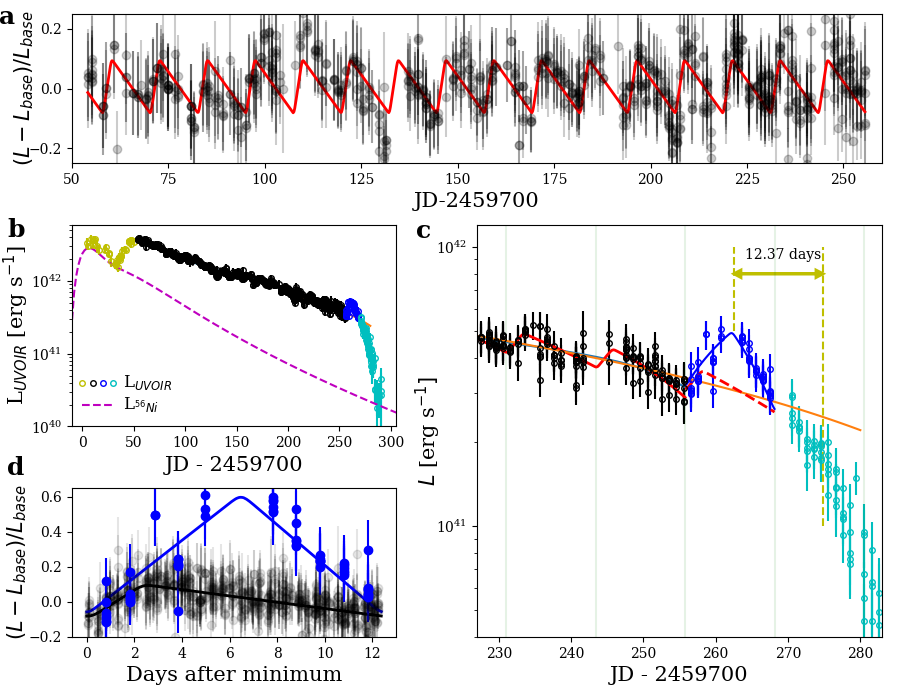

L excess: 8.669195737639886e+46
L_accretion_extrapolate: 3.024593604348385e+47
L_accretion_obs 3.891513178112374e+47
L_accretion_excess: 8.669195737639888e+46


In [406]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'serif'

fig = plt.figure(figsize=(9,7))
gs = GridSpec(12, 10, figure=fig, hspace=0.2, wspace=0.0, left=0.08, right=0.98, bottom=0.09, top=0.98)


ax1 = fig.add_subplot(gs[0:3, :])
ax2 = fig.add_subplot(gs[4:8, 0:4])
ax3 = fig.add_subplot(gs[4:12, 5:10])
ax4 = fig.add_subplot(gs[9:12, 0:4])



##### ax2

mask0 = Lbol['phase']< 50
mask1 = (Lbol['phase']> 50)*(Lbol['phase']< (21*period-Lbol_xshift))
mask2 = (Lbol['phase']> (21*period-Lbol_xshift) )*(Lbol['phase']< (22*period-Lbol_xshift))
mask3 = Lbol['phase'] > (22*period-Lbol_xshift)

#ax2.errorbar(Lbol['phase'], Lbol['L'], yerr=Lbol['eL'], fmt='ko', ms=4, mfc='none')
ax2.errorbar(Lbol['phase'][mask0], Lbol['L'][mask0], yerr=Lbol['eL'][mask0], fmt='yo', ms=4, mfc='none')
ax2.errorbar(Lbol['phase'][mask1], Lbol['L'][mask1], yerr=Lbol['eL'][mask1], fmt='ko', ms=4, mfc='none')
ax2.errorbar(Lbol['phase'][mask2], Lbol['L'][mask2], yerr=Lbol['eL'][mask2], fmt='bo', ms=4, mfc='none')
ax2.errorbar(Lbol['phase'][mask3], Lbol['L'][mask3], yerr=Lbol['eL'][mask3], fmt='co', ms=4, mfc='none')
#ax2.vlines(-4+np.arange(5,25)*12.37, ymin=3e42, ymax=5e42, linestyles='solid', colors='red', alpha=0.3)  #The vertical lines mark the minima of the undulations

xsmodel = np.linspace(5*period, 21*period, 1000) - Lbol_xshift
ysmodel = polyfunc1(fitobj1.params, xsmodel)

xsmodel2 = np.linspace(200, 280, 100)
ysmodel2 = polyfunc2(fitobj2.params, xsmodel2)

xsmodel3 = np.linspace(21*period, 22*period, 100) - Lbol_xshift
ysmodel3 = polyfunc2(fitobj2.params, xsmodel3)

ax2.plot(xsmodel, ysmodel*1e43 + Lni56_model(xsmodel))
ax2.plot(xsmodel, ( 1+ Lbol_model( (xsmodel + Lbol_xshift)%period) )* (ysmodel*1e43  + Lni56_model(xsmodel)), 'k')
ax2.plot(xsmodel2, ysmodel2*1e43+ Lni56_model(xsmodel2))
ax2.set_yscale('log')
ax2.set_ylim([1e40, 6e42])
ax2.set_xlim([-10, 305])
ax2.set_xlabel('JD - 2459700', fontsize=15)
ax2.set_ylabel(r'L$_{UVOIR}$ [erg s$^{-1}$]', fontsize=15, labelpad=0)

ax2.plot( 0, 4e40, 'yo', ms=4, mfc='none')
ax2.plot(10, 4e40, 'ko', ms=4, mfc='none')
ax2.plot(20, 4e40, 'bo', ms=4, mfc='none')
ax2.plot(30, 4e40, 'co', ms=4, mfc='none')
ax2.text(40, 4e40, r'L$_{UVOIR}$', va='center',fontsize=12)
ax2.hlines(2e40, xmin=0, xmax=30, colors='m', linestyles='dashed')
ax2.text(40, 2e40, r'L$_{^{56}Ni}$', va='center',fontsize=12)

##### ax1

data1 = np.loadtxt('../data/bolometric_light_curve/Lbol_relative_undulation.txt')
ax1.errorbar(data1[:,0], data1[:,1], yerr=data1[:,2], fmt='ko', alpha=0.2) #, mfc='none')
xtemp = np.linspace(np.min(data1[:,0]), np.max(data1[:,0]), 1000)
ax1.plot(xtemp, Lbol_model( (xtemp + Lbol_xshift)%period), 'r', lw=2)

ax1.set_xlabel('JD-2459700', fontsize=15)
ax1.set_ylabel(r'$(L - L_{base})/L_{base}$', fontsize=15, labelpad=-5)
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
ax1.set_ylim([-0.25, 0.25])
ax1.set_xlim([50, 260])

##### ax3

#ax3.errorbar(Lbol['phase'], Lbol['L'], yerr=Lbol['eL'], fmt='ko', ms=4, mfc='none')
ax3.errorbar(Lbol['phase'][mask1], Lbol['L'][mask1] - Lni56_model(Lbol['phase'][mask1]), yerr=Lbol['eL'][mask1], fmt='ko', ms=4, mfc='none')  #Ni56 power subtracted
ax3.errorbar(Lbol['phase'][mask2], Lbol['L'][mask2]- Lni56_model(Lbol['phase'][mask2]), yerr=Lbol['eL'][mask2], fmt='bo', ms=4, mfc='none')
ax3.errorbar(Lbol['phase'][mask3], Lbol['L'][mask3]- Lni56_model(Lbol['phase'][mask3]), yerr=Lbol['eL'][mask3], fmt='co', ms=4, mfc='none')

ax3.vlines(-4+np.arange(5,25)*12.37, ymin=1e40, ymax=5e42, linestyles='solid', colors='green', alpha=0.1)  #The vertical lines mark the minima of the undulations

ax3.plot(xsmodel, ysmodel*1e43)
ax3.plot(xsmodel, ( 1+ Lbol_model( (xsmodel+Lbol_xshift) %period) )* ysmodel*1e43 , 'r', lw=2)

ax3.plot(xsmodel2, ysmodel2*1e43)

f_extrapolate = ( 1+ Lbol_model( (xsmodel3+Lbol_xshift) %period) )* ysmodel3*1e43  #prediction based on extrapolation of the last bump flux if it follows the previous undulations 
f_obs = ( 1+ Lbol_model_last( (xsmodel3+Lbol_xshift) %period) )* ysmodel3*1e43 #model of the observed new behaviour of the last bump 
ax3.plot(xsmodel3,  f_extrapolate, 'r--', lw=2)
ax3.plot(xsmodel3,  f_obs, 'b')

#question: how much excess luminosity in the last bump was radiated comparing to the extrapolation of previous bumps
L_excess = np.trapz(f_obs-f_extrapolate, x=xsmodel3*24*3600)
print('L excess:', L_excess)

Lni56 = Table.read('../data/bolometric_light_curve/sn2022jli_Lbol_Ni56_modeldata.csv', format='ascii.csv')
ax2.plot(Lni56['phase']-13, Lni56['L2'], 'm--', label=r'0.15 M$_\odot$ $^{56}$Ni')
L_accretion_extrapolate = np.trapz(f_extrapolate-Lni56_model(xsmodel3), x=xsmodel3*24*3600)
L_accretion_obs = np.trapz(f_obs-Lni56_model(xsmodel3), x=xsmodel3*24*3600)
L_accretion_excess = L_accretion_obs - L_accretion_extrapolate
print('L_accretion_extrapolate:', L_accretion_extrapolate)
print('L_accretion_obs', L_accretion_obs)
print('L_accretion_excess:', L_accretion_excess)

ax3.text(264, 9e41, '12.37 days')
ax3.arrow(262.5, 8e41, 12.37, 0, head_width=5e40, head_length=1, linewidth=2, color='y', length_includes_head=True)
ax3.arrow(262.5+12.37, 8e41, -12.37, 0, head_width=5e40, head_length=1, linewidth=2, color='y', length_includes_head=True)
ax3.vlines([262.5], ymin=5e41, ymax=1e42, linestyles='dashed', colors='y', alpha=1)
ax3.vlines([262.5+12.37], ymin=1e41, ymax=1e42, linestyles='dashed', colors='y', alpha=1)


ax3.set_xlim([227, 283])
ax3.set_ylim([4e40, 1.2e42])

ax3.tick_params(labelsize=10)
ax3.set_yscale('log')
ax3.set_xlabel('JD - 2459700', fontsize=15)
ax3.set_ylabel(r'$L$ [erg s$^{-1}]$', fontsize=15, labelpad=-5)


##### ax4

xs_model = np.linspace(0, P, 200)
ys_model = construct_emperical_bump_model(xs_model, P, Lbol_params_lowestDEV[0], Lbol_params_lowestDEV[1], 0, Lbol_params_lowestDEV[3], Lbol_params_lowestDEV[4], tbin=0.1)
ax4.plot(xs_model, ys_model, lw=2, color='k')
ax4.errorbar( (xsfit+Lbol_xshift)%period, (ysfit-ys_fitret)/ys_fitret, yerr=yerrsfit/ys_fitret, fmt='ko', alpha=0.1)


data2 = np.loadtxt('../data/bolometric_light_curve/Lbol_relative_undulation_lastbump_before_phase3.txt')
ax4.errorbar( (data2[:,0]+last_xshift)%period, data2[:,1], yerr=data2[:,2], fmt='bo')

ys_model = construct_emperical_bump_model(xs_model, P, last_params_lowestDEV[0], last_params_lowestDEV[1], 0, last_params_lowestDEV[3], last_params_lowestDEV[4], tbin=0.1)
ax4.plot(xs_model, ys_model, 'b', lw=2)
ax4.set_ylim([-0.2, 0.65])

ax4.yaxis.set_major_locator(MultipleLocator(0.2))

ax4.tick_params(labelsize=10)
ax4.set_xlabel('Days after minimum',fontsize=15)
ax4.set_ylabel(r'$(L - L_{base})/L_{base}$', fontsize=15, labelpad=0)



ax1.set_title('a', fontsize=18, loc='left', pad=20, x=-0.09, y=0.75, fontweight='bold')
ax2.set_title('b', fontsize=18, loc='left', pad=20, x=-0.20, y=0.8, fontweight='bold')
ax3.set_title('c', fontsize=18, loc='left', pad=20, x=-0.15, y=0.9, fontweight='bold')
ax4.set_title('d', fontsize=18, loc='left', pad=20, x=-0.20, y=0.9, fontweight='bold')

plt.savefig('../plots/SN2022jli_Lbol_evolution_undulations.pdf')

<IPython.core.display.Javascript object>


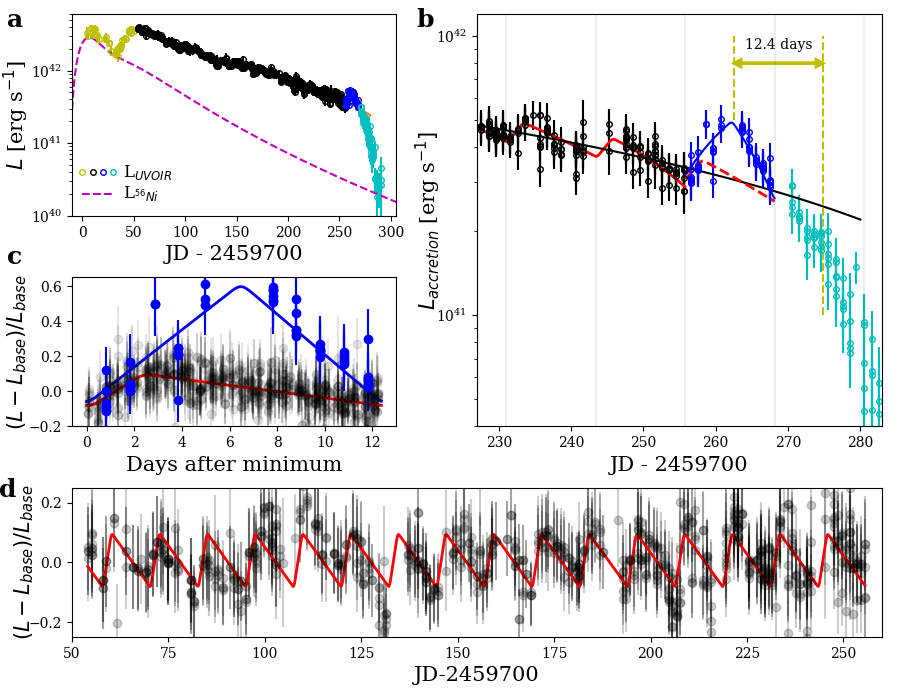

L excess: 8.669195737639886e+46
L_accretion_extrapolate: 3.024593604348385e+47
L_accretion_obs 3.891513178112374e+47
L_accretion_excess: 8.669195737639888e+46


In [419]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'serif'

fig = plt.figure(figsize=(9,7))
gs = GridSpec(12, 10, figure=fig, hspace=0.2, wspace=0.0, left=0.08, right=0.98, bottom=0.09, top=0.98)


# ax1 = fig.add_subplot(gs[0:3, :])
# ax2 = fig.add_subplot(gs[4:8, 0:4])
# ax3 = fig.add_subplot(gs[4:12, 5:10])
# ax4 = fig.add_subplot(gs[9:12, 0:4])


ax2 = fig.add_subplot(gs[0:4, 0:4])
ax3 = fig.add_subplot(gs[0:8, 5:10])
ax4 = fig.add_subplot(gs[5:8, 0:4])

ax1 = fig.add_subplot(gs[9:12, :])

##### ax2

mask0 = Lbol['phase']< 50
mask1 = (Lbol['phase']> 50)*(Lbol['phase']< (21*period-Lbol_xshift))
mask2 = (Lbol['phase']> (21*period-Lbol_xshift) )*(Lbol['phase']< (22*period-Lbol_xshift))
mask3 = Lbol['phase'] > (22*period-Lbol_xshift)

#ax2.errorbar(Lbol['phase'], Lbol['L'], yerr=Lbol['eL'], fmt='ko', ms=4, mfc='none')
ax2.errorbar(Lbol['phase'][mask0], Lbol['L'][mask0], yerr=Lbol['eL'][mask0], fmt='yo', ms=4, mfc='none')
ax2.errorbar(Lbol['phase'][mask1], Lbol['L'][mask1], yerr=Lbol['eL'][mask1], fmt='ko', ms=4, mfc='none')
ax2.errorbar(Lbol['phase'][mask2], Lbol['L'][mask2], yerr=Lbol['eL'][mask2], fmt='bo', ms=4, mfc='none')
ax2.errorbar(Lbol['phase'][mask3], Lbol['L'][mask3], yerr=Lbol['eL'][mask3], fmt='co', ms=4, mfc='none')
#ax2.vlines(-4+np.arange(5,25)*12.37, ymin=3e42, ymax=5e42, linestyles='solid', colors='red', alpha=0.3)  #The vertical lines mark the minima of the undulations

xsmodel = np.linspace(5*period, 21*period, 1000) - Lbol_xshift
ysmodel = polyfunc1(fitobj1.params, xsmodel)

xsmodel2 = np.linspace(200, 280, 100)
ysmodel2 = polyfunc2(fitobj2.params, xsmodel2)

xsmodel3 = np.linspace(21*period, 22*period, 100) - Lbol_xshift
ysmodel3 = polyfunc2(fitobj2.params, xsmodel3)

ax2.plot(xsmodel, ysmodel*1e43 + Lni56_model(xsmodel))
ax2.plot(xsmodel, ( 1+ Lbol_model( (xsmodel + Lbol_xshift)%period) )* (ysmodel*1e43  + Lni56_model(xsmodel)), 'k')
ax2.plot(xsmodel2, ysmodel2*1e43+ Lni56_model(xsmodel2))
ax2.set_yscale('log')
ax2.set_ylim([1e40, 6e42])
ax2.set_xlim([-10, 305])
ax2.set_xlabel('JD - 2459700', fontsize=15)
ax2.set_ylabel(r'$L$ [erg s$^{-1}$]', fontsize=15, labelpad=0)

ax2.plot( 0, 4e40, 'yo', ms=4, mfc='none')
ax2.plot(10, 4e40, 'ko', ms=4, mfc='none')
ax2.plot(20, 4e40, 'bo', ms=4, mfc='none')
ax2.plot(30, 4e40, 'co', ms=4, mfc='none')
ax2.text(40, 4e40, r'L$_{UVOIR}$', va='center',fontsize=12)
ax2.hlines(2e40, xmin=0, xmax=30, colors='m', linestyles='dashed')
ax2.text(40, 2e40, r'L$_{^{56}Ni}$', va='center',fontsize=12)


##### ax3

#ax3.errorbar(Lbol['phase'], Lbol['L'], yerr=Lbol['eL'], fmt='ko', ms=4, mfc='none')
ax3.errorbar(Lbol['phase'][mask1], Lbol['L'][mask1] - Lni56_model(Lbol['phase'][mask1]), yerr=Lbol['eL'][mask1], fmt='ko', ms=4, mfc='none')  #Ni56 power subtracted
ax3.errorbar(Lbol['phase'][mask2], Lbol['L'][mask2]- Lni56_model(Lbol['phase'][mask2]), yerr=Lbol['eL'][mask2], fmt='bo', ms=4, mfc='none')
ax3.errorbar(Lbol['phase'][mask3], Lbol['L'][mask3]- Lni56_model(Lbol['phase'][mask3]), yerr=Lbol['eL'][mask3], fmt='co', ms=4, mfc='none')

ax3.vlines(-4+np.arange(5,25)*12.37, ymin=1e40, ymax=5e42, linestyles='solid', colors='green', alpha=0.1)  #The vertical lines mark the minima of the undulations

#ax3.plot(xsmodel, ysmodel*1e43, 'b')
ax3.plot(xsmodel, ( 1+ Lbol_model( (xsmodel+Lbol_xshift) %period) )* ysmodel*1e43 , 'r', lw=2)

ax3.plot(xsmodel2, ysmodel2*1e43, 'k')

f_extrapolate = ( 1+ Lbol_model( (xsmodel3+Lbol_xshift) %period) )* ysmodel3*1e43  #prediction based on extrapolation of the last bump flux if it follows the previous undulations 
f_obs = ( 1+ Lbol_model_last( (xsmodel3+Lbol_xshift) %period) )* ysmodel3*1e43 #model of the observed new behaviour of the last bump 
ax3.plot(xsmodel3,  f_extrapolate, 'r--', lw=2)
ax3.plot(xsmodel3,  f_obs, 'b')

#question: how much excess luminosity in the last bump was radiated comparing to the extrapolation of previous bumps
L_excess = np.trapz(f_obs-f_extrapolate, x=xsmodel3*24*3600)
print('L excess:', L_excess)

Lni56 = Table.read('../data/bolometric_light_curve/sn2022jli_Lbol_Ni56_modeldata.csv', format='ascii.csv')
ax2.plot(Lni56['phase']-13, Lni56['L2'], 'm--', label=r'0.15 M$_\odot$ $^{56}$Ni')
L_accretion_extrapolate = np.trapz(f_extrapolate-Lni56_model(xsmodel3), x=xsmodel3*24*3600)
L_accretion_obs = np.trapz(f_obs-Lni56_model(xsmodel3), x=xsmodel3*24*3600)
L_accretion_excess = L_accretion_obs - L_accretion_extrapolate
print('L_accretion_extrapolate:', L_accretion_extrapolate)
print('L_accretion_obs', L_accretion_obs)
print('L_accretion_excess:', L_accretion_excess)

ax3.text(264, 9e41, '12.4 days')
ax3.arrow(262.5, 8e41, 12.37, 0, head_width=5e40, head_length=1, linewidth=2, color='y', length_includes_head=True)
ax3.arrow(262.5+12.37, 8e41, -12.37, 0, head_width=5e40, head_length=1, linewidth=2, color='y', length_includes_head=True)
ax3.vlines([262.5], ymin=5e41, ymax=1e42, linestyles='dashed', colors='y', alpha=1)
ax3.vlines([262.5+12.37], ymin=1e41, ymax=1e42, linestyles='dashed', colors='y', alpha=1)


ax3.set_xlim([227, 283])
ax3.set_ylim([4e40, 1.2e42])

ax3.tick_params(labelsize=10)
ax3.set_yscale('log')
ax3.set_xlabel('JD - 2459700', fontsize=15)
ax3.set_ylabel(r'$L_{accretion}$ [erg s$^{-1}]$', fontsize=15, labelpad=-5)


##### ax4

xs_model = np.linspace(0, P, 200)
ys_model = construct_emperical_bump_model(xs_model, P, Lbol_params_lowestDEV[0], Lbol_params_lowestDEV[1], 0, Lbol_params_lowestDEV[3], Lbol_params_lowestDEV[4], tbin=0.1)
ax4.errorbar( (xsfit+Lbol_xshift)%period, (ysfit-ys_fitret)/ys_fitret, yerr=yerrsfit/ys_fitret, fmt='ko', alpha=0.1)
ax4.plot(xs_model, ys_model, lw=2, color='r')

data2 = np.loadtxt('../data/bolometric_light_curve/Lbol_relative_undulation_lastbump_before_phase3.txt')
ax4.errorbar( (data2[:,0]+last_xshift)%period, data2[:,1], yerr=data2[:,2], fmt='bo')

ys_model = construct_emperical_bump_model(xs_model, P, last_params_lowestDEV[0], last_params_lowestDEV[1], 0, last_params_lowestDEV[3], last_params_lowestDEV[4], tbin=0.1)
ax4.plot(xs_model, ys_model, 'b', lw=2)
ax4.set_ylim([-0.2, 0.65])

ax4.yaxis.set_major_locator(MultipleLocator(0.2))

ax4.tick_params(labelsize=10)
ax4.set_xlabel('Days after minimum',fontsize=15)
ax4.set_ylabel(r'$(L - L_{base})/L_{base}$', fontsize=15, labelpad=0)


##### ax1

data1 = np.loadtxt('../data/bolometric_light_curve/Lbol_relative_undulation.txt')
ax1.errorbar(data1[:,0], data1[:,1], yerr=data1[:,2], fmt='ko', alpha=0.2) #, mfc='none')
xtemp = np.linspace(np.min(data1[:,0]), np.max(data1[:,0]), 1000)
ax1.plot(xtemp, Lbol_model( (xtemp + Lbol_xshift)%period), 'r', lw=2)

ax1.set_xlabel('JD-2459700', fontsize=15)
ax1.set_ylabel(r'$(L - L_{base})/L_{base}$', fontsize=15, labelpad=-5)
ax1.yaxis.set_major_locator(MultipleLocator(0.2))
ax1.set_ylim([-0.25, 0.25])
ax1.set_xlim([50, 260])

########

ax2.set_title('a', fontsize=18, loc='left', pad=20, x=-0.20, y=0.8, fontweight='bold')
ax3.set_title('b', fontsize=18, loc='left', pad=20, x=-0.15, y=0.9, fontweight='bold')
ax4.set_title('c', fontsize=18, loc='left', pad=20, x=-0.20, y=0.9, fontweight='bold')
ax1.set_title('d', fontsize=18, loc='left', pad=20, x=-0.09, y=0.75, fontweight='bold')

plt.savefig('../plots/SN2022jli_Lbol_evolution_undulations.pdf')

In [290]:
epsilon = 0.1
Macc = 5e-7*constants.M_sun
E = epsilon*Macc*constants.c**2
print(E.cgs)

8.935468343706397e+46 erg
